In [1]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

In [2]:
from my_nn_modules import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [23]:
# Load data
#train = pd.read_pickle(BIN + 'processed_data/aod/partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/partial_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/full_test.pkl')

train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_test.pkl')

train['pt'] = train['pt'] / 1000.  # Convert to GeV
test['pt'] = test['pt'] / 1000.  # Convert to GeV
train['m'] = train['m'] / 1000.  # Convert to GeV
test['m'] = test['m'] / 1000.  # Convert to GeV

train['LeadingClusterPt'] = train['LeadingClusterPt'] / 1000.  # Convert to GeV
test['LeadingClusterPt'] = test['LeadingClusterPt'] / 1000.  # Convert to GeV

train['LeadingClusterSecondR'] = train['LeadingClusterSecondR'] / 1000.  # Convert to GeV
test['LeadingClusterSecondR'] = test['LeadingClusterSecondR'] / 1000.  # Convert to GeV

train['LeadingClusterSecondLambda'] = train['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV
test['LeadingClusterSecondLambda'] = test['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV

train['NegativeE'] = train['NegativeE'] / 1000.  # Convert to GeV
test['NegativeE'] = test['NegativeE'] / 1000.  # Convert to GeV

train.pop('JetGhostArea')
test.pop('JetGhostArea')
train.pop('BchCorrCell')
test.pop('BchCorrCell')

#train.pop('ActiveArea')
#test.pop('ActiveArea')
#train.pop('ActiveArea4vec_pt')
#test.pop('ActiveArea4vec_pt')
#train.pop('N90Constituents')
#test.pop('N90Constituents')


# Remove all jets with EMFrac outside (-2, 2)
train = train[(np.abs(train['EMFrac']) < 2)]
test = test[(np.abs(test['EMFrac']) < 2)]

train = train[np.invert((np.abs(train['EMFrac']) < 0.05) & (np.abs(train['eta']) >= 2))]
test = test[np.invert((np.abs(test['EMFrac']) < 0.05) & (np.abs(test['eta']) >= 2))]

train = train[np.invert((train['AverageLArQF'] > .8) & (train['EMFrac'] > .95) & (train['LArQuality'] > .8) & (np.abs(train['eta']) < 2.8))]
test = test[np.invert((test['AverageLArQF'] > .8) & (test['EMFrac'] > .95) & (test['LArQuality'] > .8) & (np.abs(test['eta']) < 2.8))]

train = train[np.abs(train['NegativeE']) < 60]
test = test[np.abs(test['NegativeE']) < 60]

# Filter out extreme jets
train = train[np.invert((train['AverageLArQF'] > .8) & (np.abs(train['HECQuality']) > 0.5) & (np.abs(train['HECFrac']) > 0.5))]
test = test[np.invert((test['AverageLArQF'] > .8) & (np.abs(test['HECQuality']) > 0.5) & (np.abs(test['HECFrac']) > 0.5))]

train = train[train['OotFracClusters10'] > -0.1]
test = test[test['OotFracClusters10'] > -0.1]
train = train[train['OotFracClusters5'] > -0.1]
test = test[test['OotFracClusters5'] > -0.1]

train = train[train['Width'] < 100]
test = test[test['Width'] < 100]

train = train[train['WidthPhi'] < 100]
test = test[test['WidthPhi'] < 100]
          
train = train[np.abs(train['Timing']) < 120]
test = test[np.abs(test['Timing']) < 120]

train = train[train['LArQuality'] < 2]
test = test[test['LArQuality'] < 2]

train = train[train['HECQuality'] > -100000]
test = test[test['HECQuality'] > -100000]

train = train[train['m'] > 1e-3]
test = test[test['m'] > 1e-3]

In [ ]:
def filter_jets(train):
    train['pt'] = train['pt'] / 1000.  # Convert to GeV
    train['m'] = train['m'] / 1000.  # Convert to GeV

    train['LeadingClusterPt'] = train['LeadingClusterPt'] / 1000.  # Convert to GeV

    train['LeadingClusterSecondR'] = train['LeadingClusterSecondR'] / 1000.  # Convert to GeV

    train['LeadingClusterSecondLambda'] = train['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV

    train['NegativeE'] = train['NegativeE'] / 1000.  # Convert to GeV

    train.pop('JetGhostArea')
    train.pop('BchCorrCell')

    # Remove all jets with EMFrac outside (-2, 2)
    train = train[(np.abs(train['EMFrac']) < 2)]

    train = train[np.invert((np.abs(train['EMFrac']) < 0.05) & (np.abs(train['eta']) >= 2))]

    train = train[np.invert((train['AverageLArQF'] > .8) & (train['EMFrac'] > .95) & (train['LArQuality'] > .8) & (np.abs(train['eta']) < 2.8))]

    train = train[np.abs(train['NegativeE']) < 60]

    # Filter out extreme jets
    train = train[np.invert((train['AverageLArQF'] > .8) & (np.abs(train['HECQuality']) > 0.5) & (np.abs(train['HECFrac']) > 0.5))]

    train = train[train['OotFracClusters10'] > -0.1]
    train = train[train['OotFracClusters5'] > -0.1]

    train = train[train['Width'] < 100]

    train = train[train['WidthPhi'] < 100]

    train = train[np.abs(train['Timing']) < 120]

    train = train[train['LArQuality'] < 2]

    train = train[train['HECQuality'] > -100000]

    train = train[train['m'] > 1e-3]

    return train

In [24]:
train.shape

(10576455, 27)

In [25]:
for key in test.keys():
    print(key)

pt
eta
phi
m
ActiveArea
ActiveArea4vec_eta
ActiveArea4vec_m
ActiveArea4vec_phi
ActiveArea4vec_pt
AverageLArQF
NegativeE
HECQuality
LArQuality
Width
WidthPhi
CentroidR
DetectorEta
LeadingClusterCenterLambda
LeadingClusterPt
LeadingClusterSecondLambda
LeadingClusterSecondR
N90Constituents
EMFrac
HECFrac
Timing
OotFracClusters10
OotFracClusters5


In [26]:
len(train.keys())

27

In [27]:
plt.close('all')

In [28]:
train.head()

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
10841203,76.395562,2.551444,-0.644569,8.928354,0.528585,2.589474,0.151597,-0.652557,0.517514,1038.006104,...,1195.811523,39.840117,44.922352,8.611044,4.0,0.302607,0.696391,0.244543,0.000000,0.000000
2478188,28.675375,0.900313,-1.952856,7.881052,0.508639,0.916086,0.147628,-1.951760,0.499531,122.948654,...,25.230358,7.836223,28.356055,7.591930,12.0,0.766227,0.000000,1.181435,0.065003,0.221785
3171379,167.436844,0.194945,-2.188446,13.721005,0.518612,0.209248,0.150651,-2.178825,0.508215,56.737061,...,1502.329102,64.280051,34.982254,119.096180,4.0,0.411470,0.000000,0.246874,0.015531,0.015531
10616755,34.359961,1.563726,0.265730,5.162133,0.478719,1.581886,0.134544,0.258161,0.470514,75.541565,...,1101.789062,19.374385,538.964500,33.847000,5.0,0.443485,0.276325,-2.783324,0.112619,0.112619
3493566,22.086941,1.128521,-1.433368,3.426685,0.378986,1.075723,0.102861,-1.408685,0.371212,369.198914,...,2315.847412,3.837655,59.464027,4.555738,4.0,0.543178,0.000000,-5.062422,0.315627,0.485570


In [29]:
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

In [30]:
plt.close('all')

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


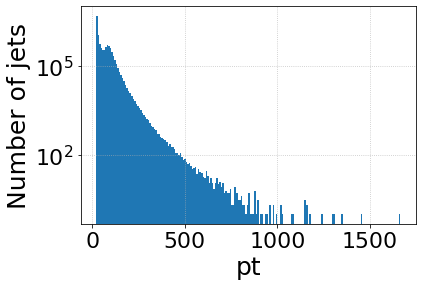

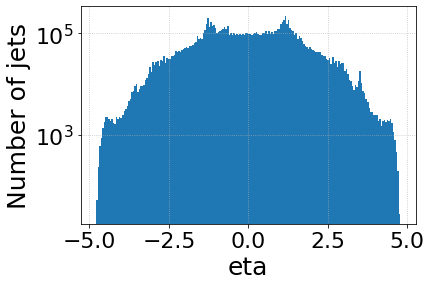

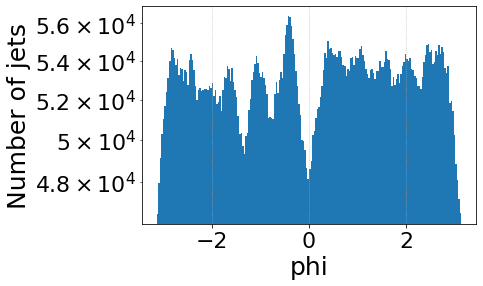

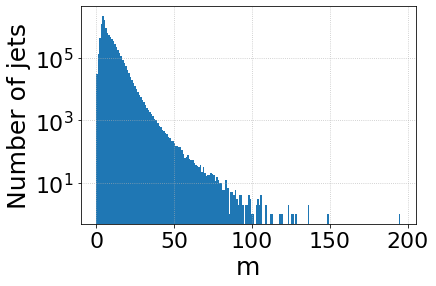

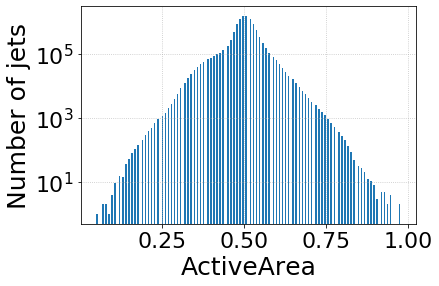

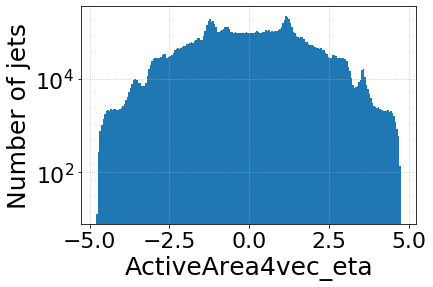

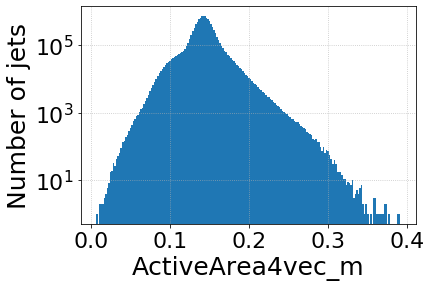

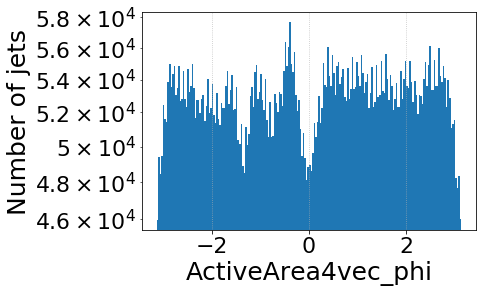

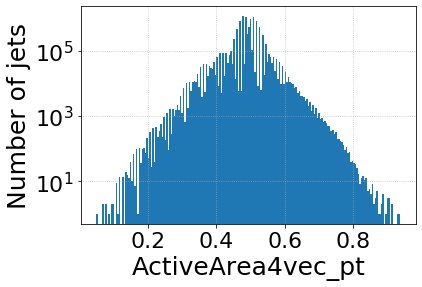

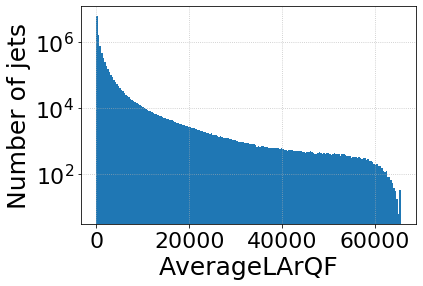

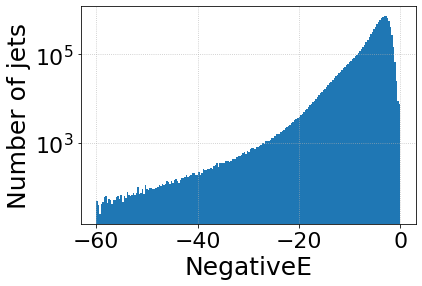

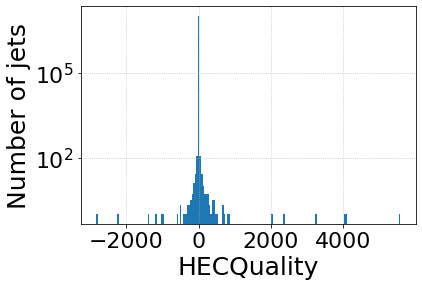

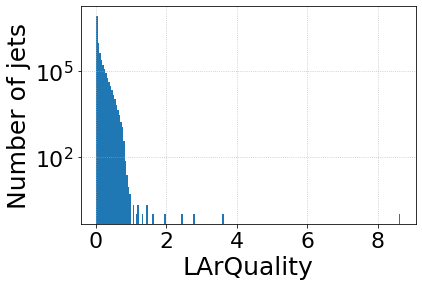

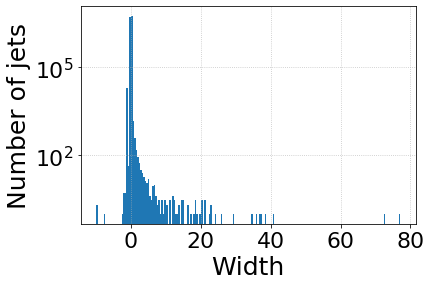

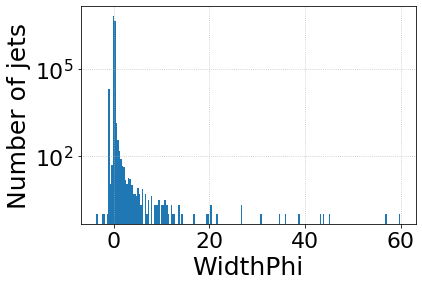

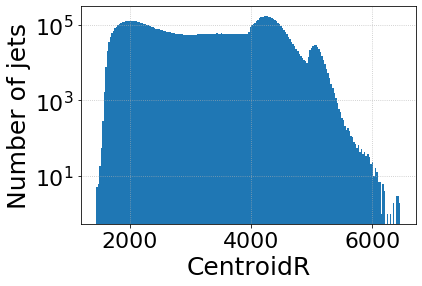

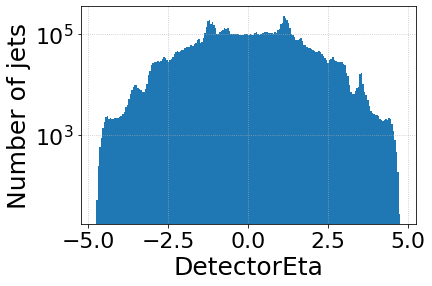

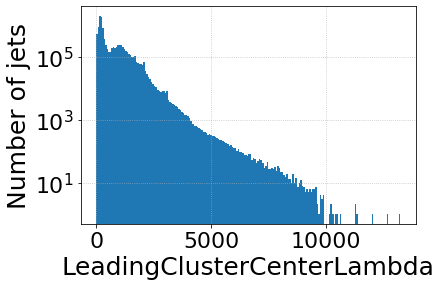

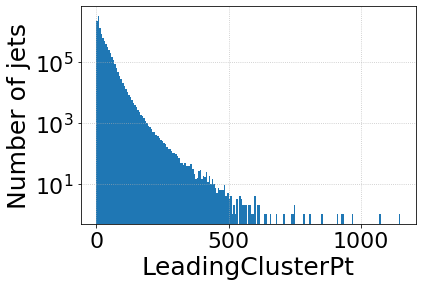

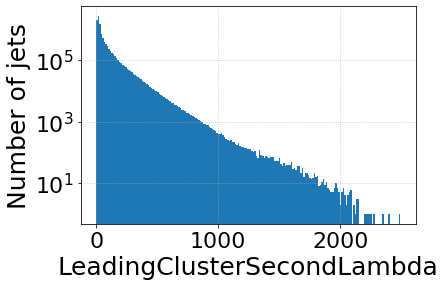

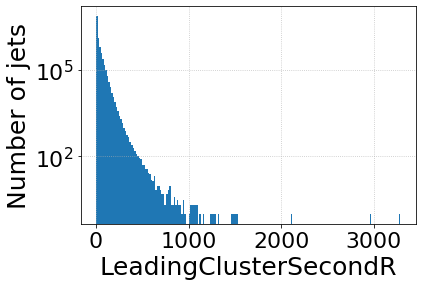

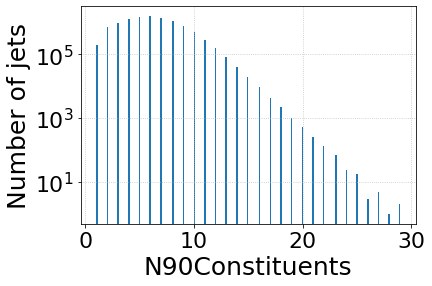

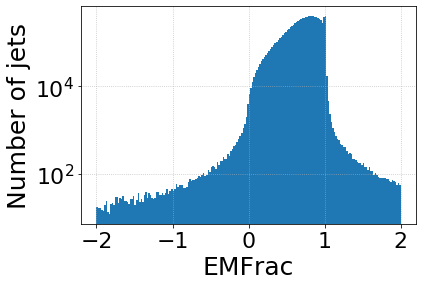

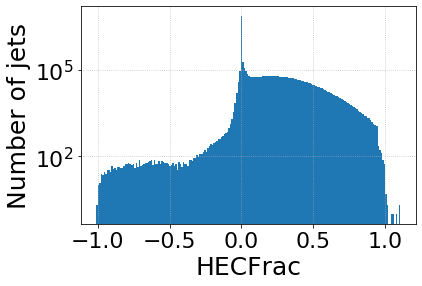

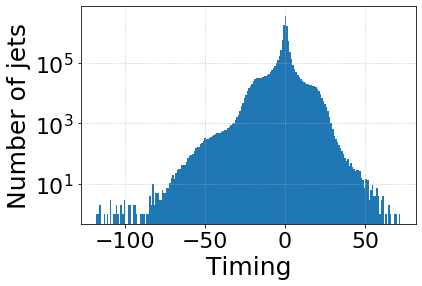

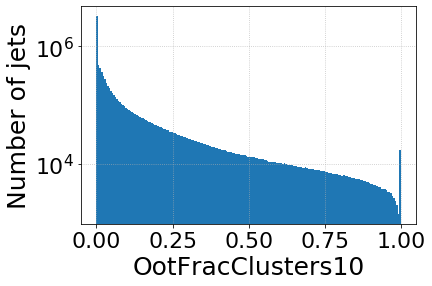

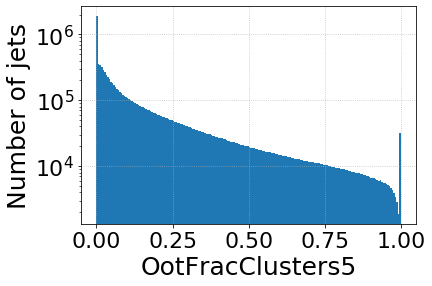

In [31]:
logy = True
plot_all(train, logy)

In [22]:
keys = []
custom_variables = [
                    'OotFracClusters10',
                    'OotFracClusters5',
                    'pt',
                    'LeadingClusterCenterLambda',
                    'LeadingClusterSecondLambda',
                    'LeadingClusterSecondR',
                    'CentroidR',
                    'LeadingClusterPt',
                    'AverageLArQF',
                    'eta',
                    'phi',
                    'DetectorEta',
                    'ActiveArea4vec_eta',
                    'EMFrac',
                    'NegativeE',
                    'm',
                    'ActiveArea4vec_phi',
                    'Width',
                    'WidthPhi',
                    'N90Constituents',
                    'Timing',
                    'HECQuality',
                    ]
notnormed_variables = ['ActiveArea',
                       'ActiveArea4vec_m',
                       'ActiveArea4vec_pt',
                       'HECFrac',
                       'LArQuality',                       
                      ]
all_vars = keys + custom_variables + notnormed_variables
len(all_vars)

27

In [57]:
custom_normalized_test = test.copy()

custom_normalized_test['DetectorEta'] = test['DetectorEta'] / 5
custom_normalized_test['ActiveArea4vec_eta'] = test['ActiveArea4vec_eta'] / 5
custom_normalized_test['EMFrac'] = test['EMFrac'] / 2
custom_normalized_test['NegativeE'] = np.log10(-test['NegativeE'] + 1) / 4
custom_normalized_test['eta'] = test['eta'] / 5
custom_normalized_test['phi'] = test['phi'] / 3
custom_normalized_test['m'] = test['m'] / 100
custom_normalized_test['ActiveArea4vec_phi'] = test['ActiveArea4vec_phi'] / 3
custom_normalized_test['Width'] = test['Width'] / 10
custom_normalized_test['WidthPhi'] = test['WidthPhi'] / 10
custom_normalized_test['N90Constituents'] = test['N90Constituents'] / 20
custom_normalized_test['Timing'] = test['Timing'] / 100
custom_normalized_test['HECQuality'] = test['HECQuality'] / 100

custom_normalized_test['LeadingClusterCenterLambda'] = (np.log10(test['LeadingClusterCenterLambda'] + 100) - 2) / 2
custom_normalized_test['LeadingClusterSecondLambda'] = np.log10(test['LeadingClusterSecondLambda'] + 100) - 2
custom_normalized_test['LeadingClusterSecondR'] = np.log10(test['LeadingClusterSecondR'] + 100) - 2
custom_normalized_test['AverageLArQF'] = (np.log10(test['AverageLArQF'] + 100) - 2) / 2
custom_normalized_test['pt'] = (np.log10(test['pt']) - 1) / 2
custom_normalized_test['LeadingClusterPt'] = np.log10(test['LeadingClusterPt']) / 2
custom_normalized_test['CentroidR'] = (np.log10(test['CentroidR']) - 3) / 0.8
custom_normalized_test['OotFracClusters10'] = (np.log10(test['OotFracClusters10'] + 1)) / 0.01 
custom_normalized_test['OotFracClusters5'] = (np.log10(test['OotFracClusters5'] + 1)) / 0.01

In [44]:
eta_div = 5
emfrac_div = 2
negE_div = 4
phi_div = 3
m_div = 1.8
width_div = 2
N90_div = 20
timing_div = 100
hecq_div = 60
centerlambda_div = 2
secondlambda_div = 1
secondR_div = 1
larqf_div = 2
pt_div = 2
centroidR_div = 0.8
area4vecm_div = 0.3
area4vecpt_div = 0.8
area4vec_div = 0.8
Oot_div = 0.3
larq_div = 0.6

log_add = 100
log_sub = 2
centroidR_sub = 3
pt_sub = 1
area4vecm_sub = 0.15
    

def custom_normalization(train, test):
    train_cp = train.copy()
    test_cp = test.copy()
    
    for data in [train_cp, test_cp]:
        data['DetectorEta'] = data['DetectorEta'] / eta_div
        data['ActiveArea4vec_eta'] = data['ActiveArea4vec_eta'] / eta_div
        data['EMFrac'] = data['EMFrac'] / emfrac_div
        data['NegativeE'] = np.log10(-data['NegativeE'] + 1) / negE_div
        data['eta'] = data['eta'] / eta_div
        data['phi'] = data['phi'] / phi_div
        data['m'] = np.log10(data['m']) / m_div
        data['ActiveArea4vec_phi'] = data['ActiveArea4vec_phi'] / phi_div
        data['Width'] = data['Width'] / width_div
        data['WidthPhi'] = data['WidthPhi'] / width_div
        data['N90Constituents'] = data['N90Constituents'] / N90_div
        data['Timing'] = data['Timing'] / timing_div
        data['HECQuality'] = data['HECQuality'] / hecq_div
        data['ActiveArea'] = data['ActiveArea'] / area4vec_div
        data['ActiveArea4vec_m'] = data['ActiveArea4vec_m'] / area4vecm_div - area4vecm_sub
        data['ActiveArea4vec_pt'] = data['ActiveArea4vec_pt'] / area4vecpt_div
        data['LArQuality'] = data['LArQuality'] / larq_div

        data['LeadingClusterCenterLambda'] = (np.log10(data['LeadingClusterCenterLambda'] + log_add) - log_sub) / centerlambda_div
        data['LeadingClusterSecondLambda'] = (np.log10(data['LeadingClusterSecondLambda'] + log_add) - log_sub) / secondlambda_div
        data['LeadingClusterSecondR'] = (np.log10(data['LeadingClusterSecondR'] + log_add) - log_sub) / secondR_div
        data['AverageLArQF'] = (np.log10(data['AverageLArQF'] + log_add) - log_sub) / larqf_div
        data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div
        data['LeadingClusterPt'] = np.log10(data['LeadingClusterPt']) / pt_div
        data['CentroidR'] = (np.log10(data['CentroidR']) - centroidR_sub) / centroidR_div
        data['OotFracClusters10'] = np.log10(data['OotFracClusters10'] + 1) / Oot_div
        data['OotFracClusters5'] = np.log10(data['OotFracClusters5'] + 1) / Oot_div
        
    return train_cp, test_cp


def custom_unnormalize(normalized_data):
    data = normalized_data.copy()
    data['DetectorEta'] = data['DetectorEta'] * eta_div
    data['ActiveArea4vec_eta'] = data['ActiveArea4vec_eta'] * eta_div
    data['EMFrac'] = data['EMFrac'] * emfrac_div
    data['eta'] = data['eta'] * eta_div
    data['phi'] = data['phi'] * phi_div
    data['ActiveArea4vec_phi'] = data['ActiveArea4vec_phi'] * phi_div
    data['Width'] = data['Width'] * width_div
    data['WidthPhi'] = data['WidthPhi'] * width_div
    data['N90Constituents'] = data['N90Constituents'] * N90_div
    data['Timing'] = data['Timing'] * timing_div
    data['HECQuality'] = data['HECQuality'] * hecq_div
    data['ActiveArea'] = data['ActiveArea'] * area4vec_div
    data['ActiveArea4vec_m'] = (data['ActiveArea4vec_m'] + area4vecm_sub) * area4vecm_div
    data['ActiveArea4vec_pt'] = data['ActiveArea4vec_pt'] * area4vecpt_div
    data['LArQuality'] = data['LArQuality'] * larq_div

    data['NegativeE'] = 1 - np.power(10, negE_div * data['NegativeE'])
    data['m'] = np.power(10, m_div * data['m'])
    data['LeadingClusterCenterLambda'] = np.power(10, centerlambda_div * data['LeadingClusterCenterLambda'] + log_sub) - log_add
    data['LeadingClusterSecondLambda'] = np.power(10, secondlambda_div * data['LeadingClusterSecondLambda'] + log_sub) - log_add
    data['LeadingClusterSecondR'] = np.power(10, secondR_div * data['LeadingClusterSecondR'] + log_sub) - log_add
    data['AverageLArQF'] = np.power(10, larqf_div * data['AverageLArQF'] + log_sub) - log_add
    data['pt'] = np.power(10, pt_div * data['pt'] + pt_sub)
    data['LeadingClusterPt'] = np.power(10, pt_div * data['LeadingClusterPt'])
    data['CentroidR'] = np.power(10, centroidR_div * data['CentroidR'] + centroidR_sub)
    data['OotFracClusters10'] = np.power(10, Oot_div * data['OotFracClusters10']) - 1
    data['OotFracClusters5'] = np.power(10, Oot_div * data['OotFracClusters5']) - 1
    
    return data


    
    
    

In [45]:
custom_normalized_train, custom_normalized_test = custom_normalization(train, test)
#unnormalized_test = custom_unnormalize(custom_normalized_test)

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


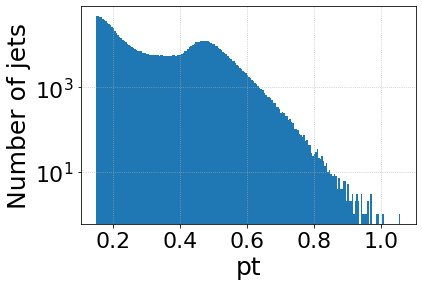

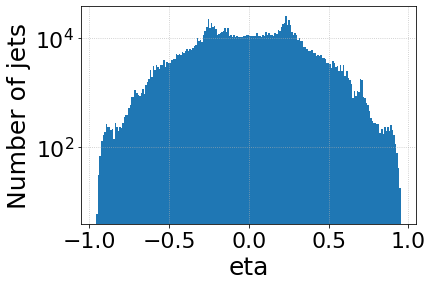

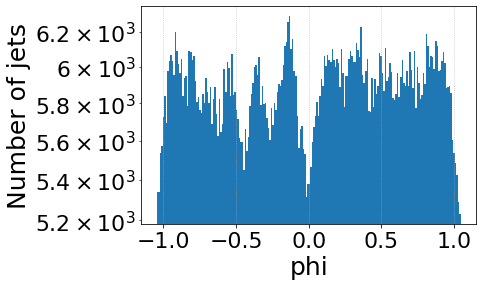

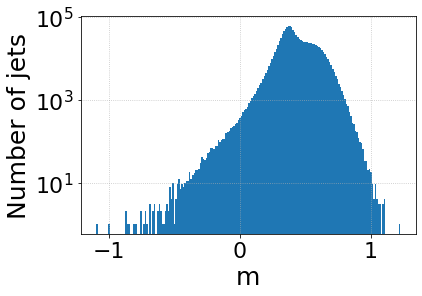

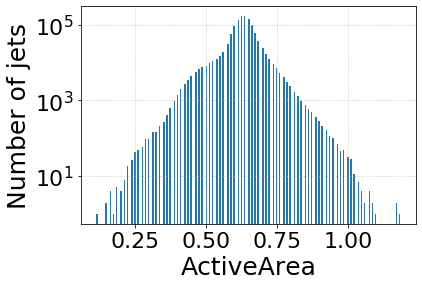

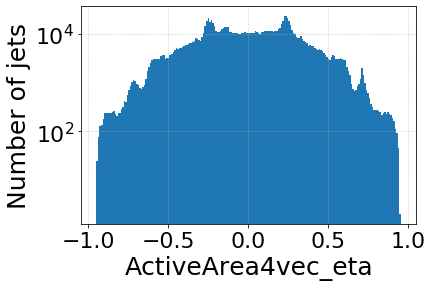

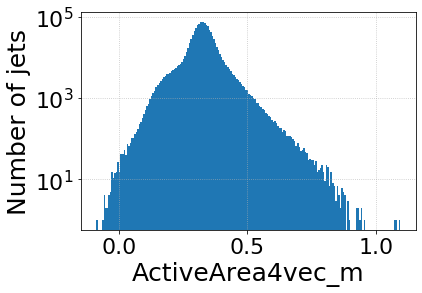

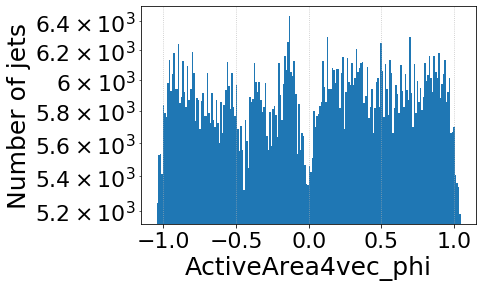

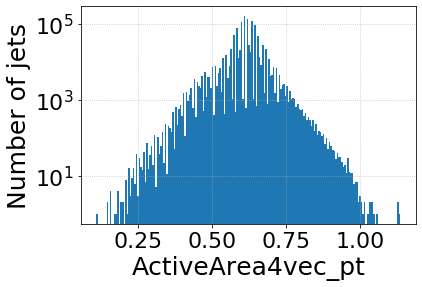

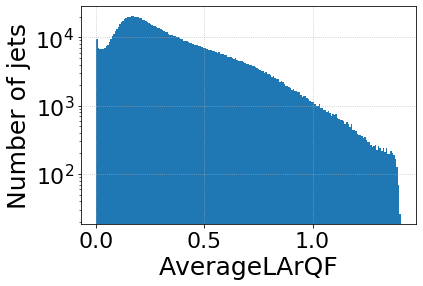

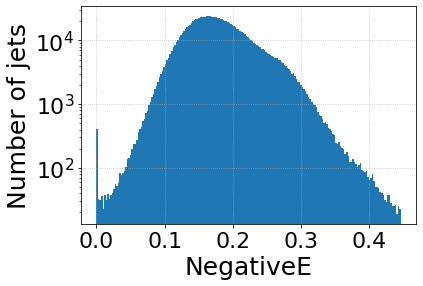

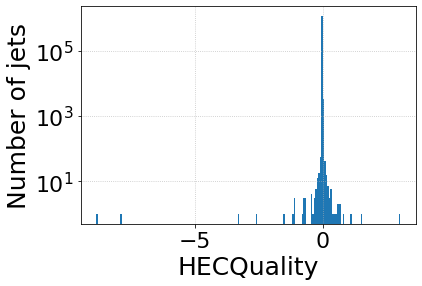

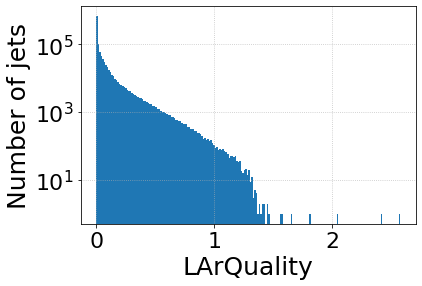

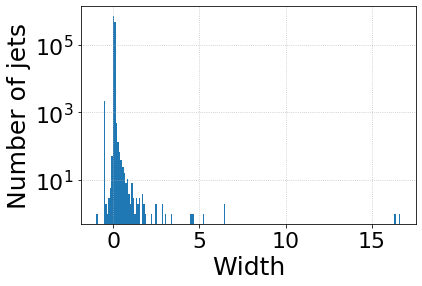

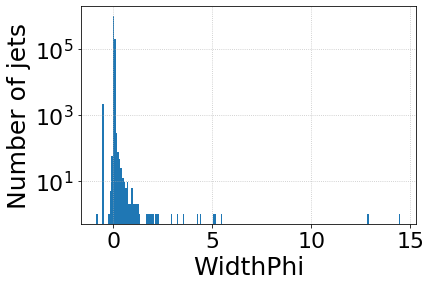

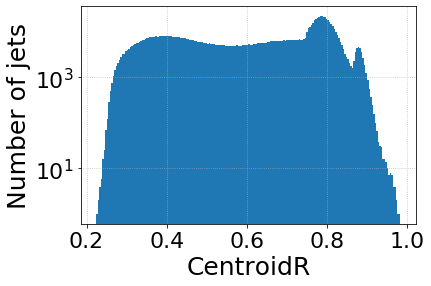

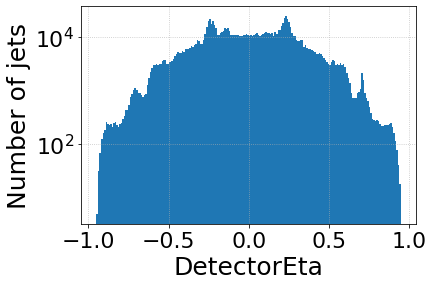

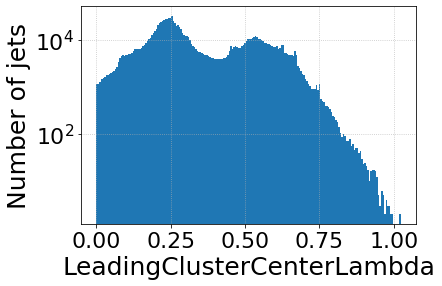

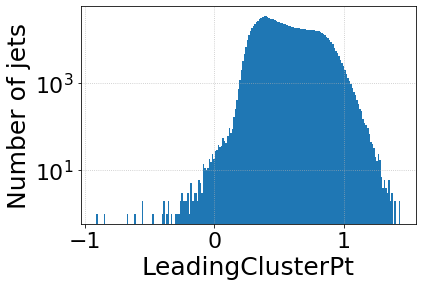

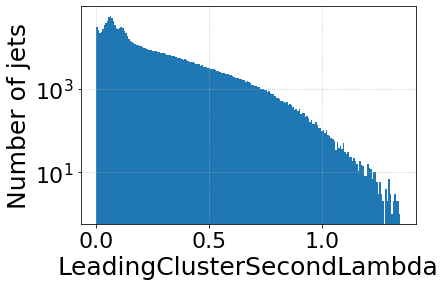

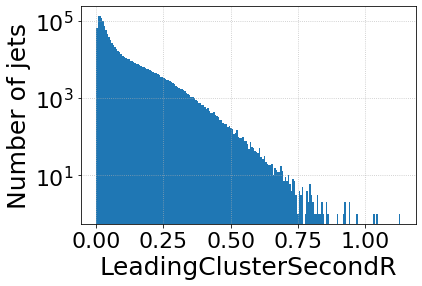

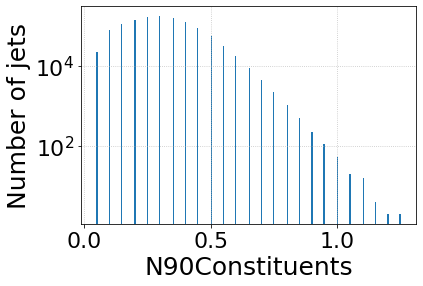

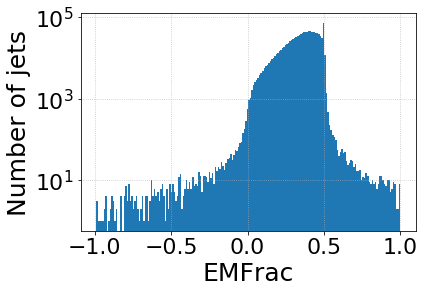

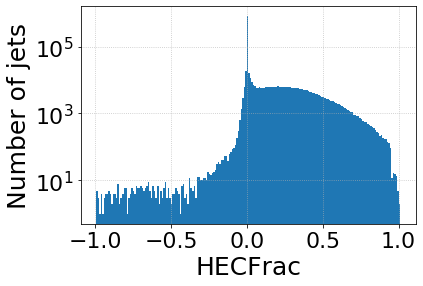

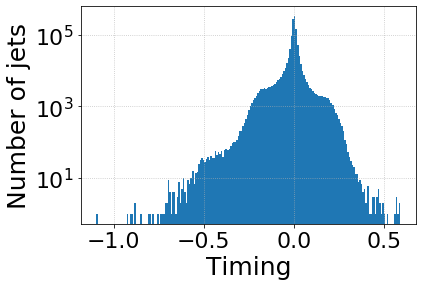

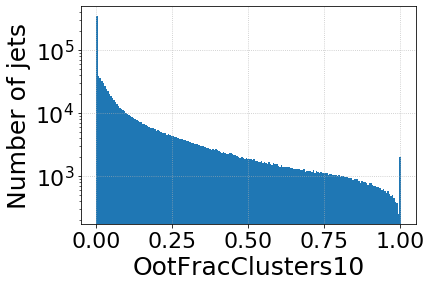

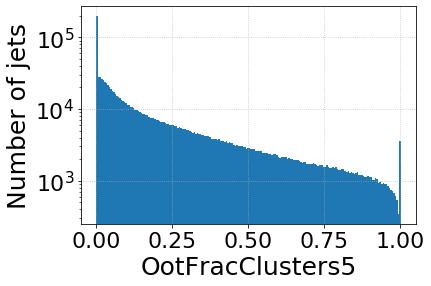

In [46]:
plot_all(custom_normalized_test, logy)

In [47]:
plt.close('all')

In [12]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

In [23]:
from my_nn_modules import AE_bn_LeakyReLU

In [42]:
train_ds = TensorDataset(torch.tensor(custom_normalized_train.values, dtype=torch.float), torch.tensor(custom_normalized_train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(custom_normalized_test.values, dtype=torch.float), torch.tensor(custom_normalized_test.values, dtype=torch.float))

In [43]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [44]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1024)

In [45]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [46]:
custom_normalized_test.shape

(1176414, 24)

In [47]:
24/18

1.3333333333333333

In [48]:
nodes = [24, 200, 200, 200, 18, 200, 200, 200, 24]
model = AE_bn_LeakyReLU(nodes)
model.train()

AE_bn_LeakyReLU(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=18, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=Tru

In [49]:
loss_func = nn.MSELoss()



In [50]:
wd = 1e-6
from fastai.callbacks import ActivationStats
learn = basic_train.Learner(data=db, model=model, wd=wd, loss_func=loss_func, callback_fns=ActivationStats, true_wd=True)

In [51]:
from fastai import train as tr
tr.lr_find(learn, stop_div=True, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


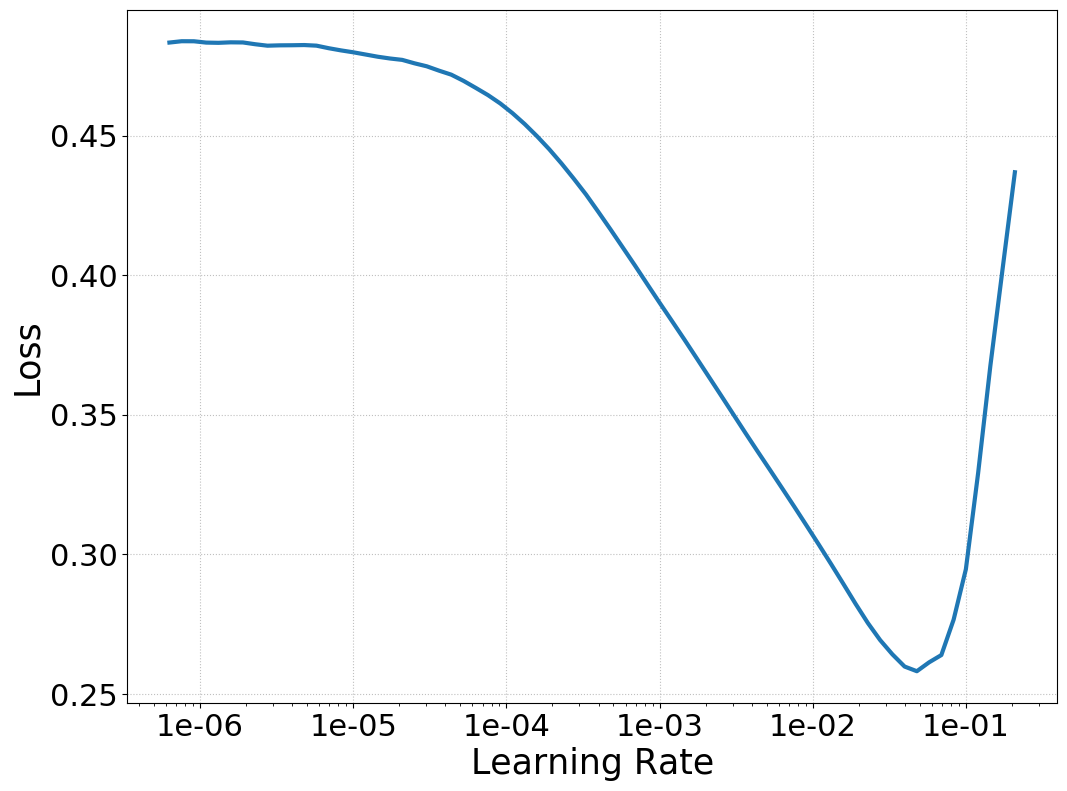

In [52]:
learn.recorder.plot()

In [53]:
lr = 1e-3
learn.fit_one_cycle(400, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.001034,0.000930,35:45
1,0.000730,0.000842,35:30
2,0.000545,0.000445,35:59
3,0.000448,0.000341,34:52
4,0.000407,0.000273,34:58
5,0.000373,0.000274,35:03
6,0.000349,0.000240,35:20
7,0.000339,0.000225,35:44
8,0.000313,0.000181,35:23
9,0.000329,0.000185,35:24


KeyboardInterrupt: 

In [ ]:
#learn.save('200_custom_norm_over_night')

In [1]:
ls models

200_custom_norm_over_night2.pth       best_bs2048_lr0.01_wd0.1.pth
27-400-400-200-18-200-400-400-27.pth  tmp.pth
best_bs2048_lr0.0001_wd0.1.pth


In [2]:
pwd

'/Users/ericwulff/Documents/LTH/Examensarbete/lth_thesis_project/jet_by_jet_compression/aod_compression'

In [54]:
lr = 1e-3
learn.fit_one_cycle(2, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.000397,0.000459,33:08
1,0.000130,0.000084,32:56


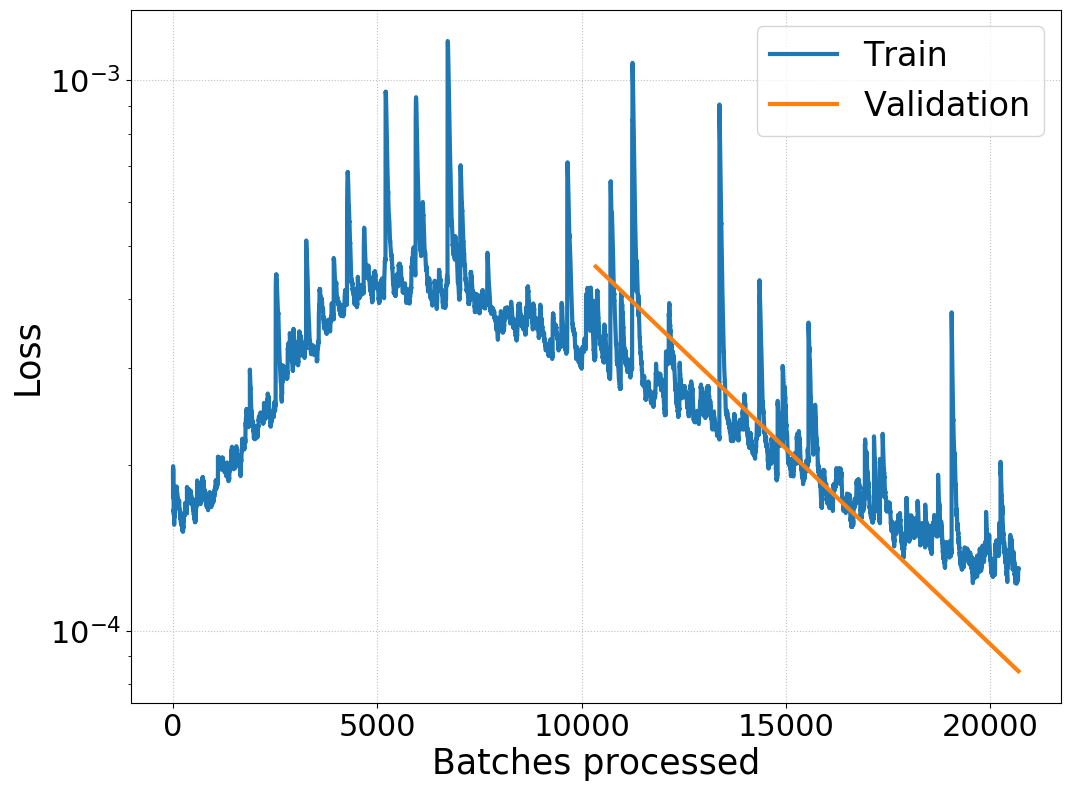

In [55]:
learn.recorder.plot_losses()
plt.yscale('log')

In [81]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(custom_normalized_test[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data).detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


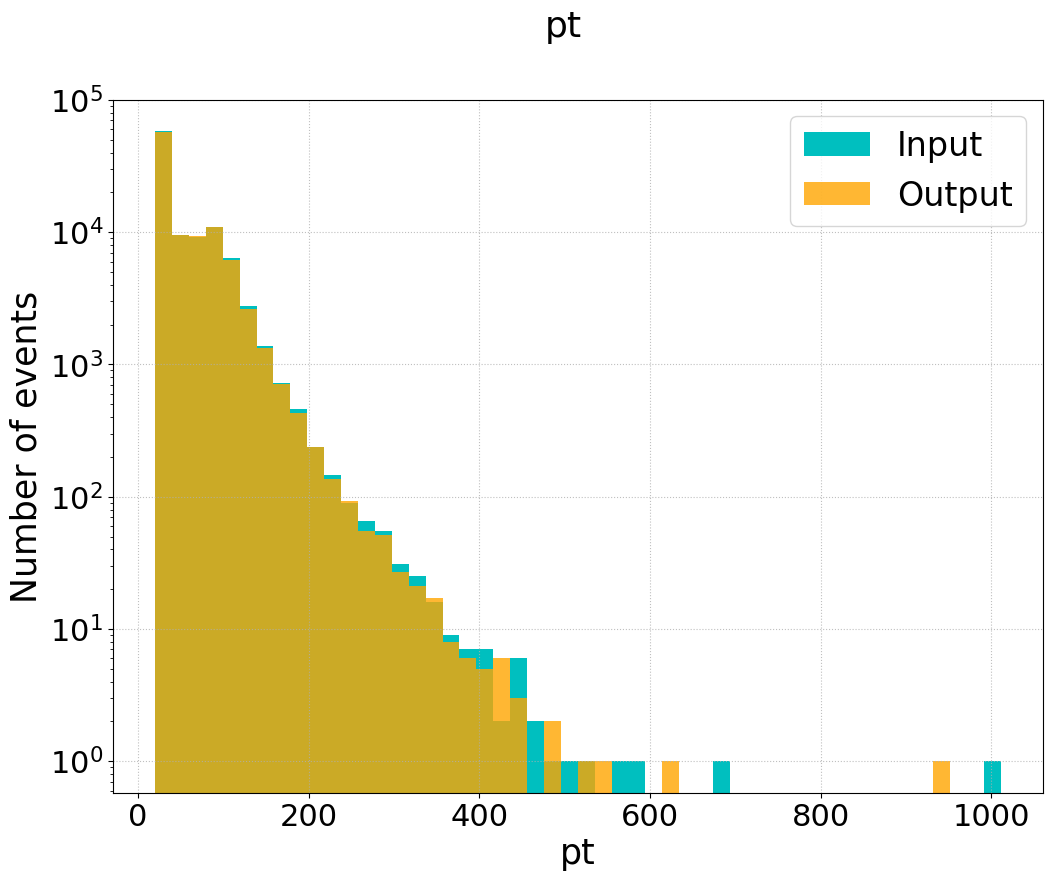

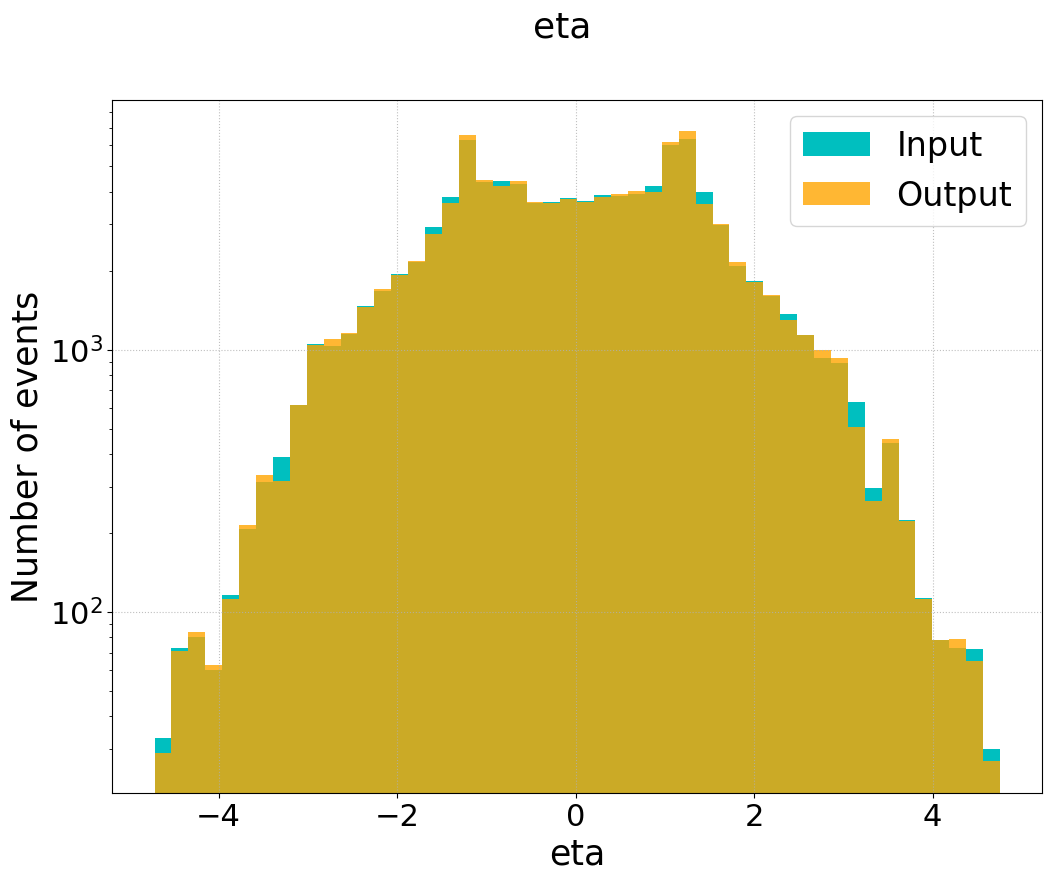

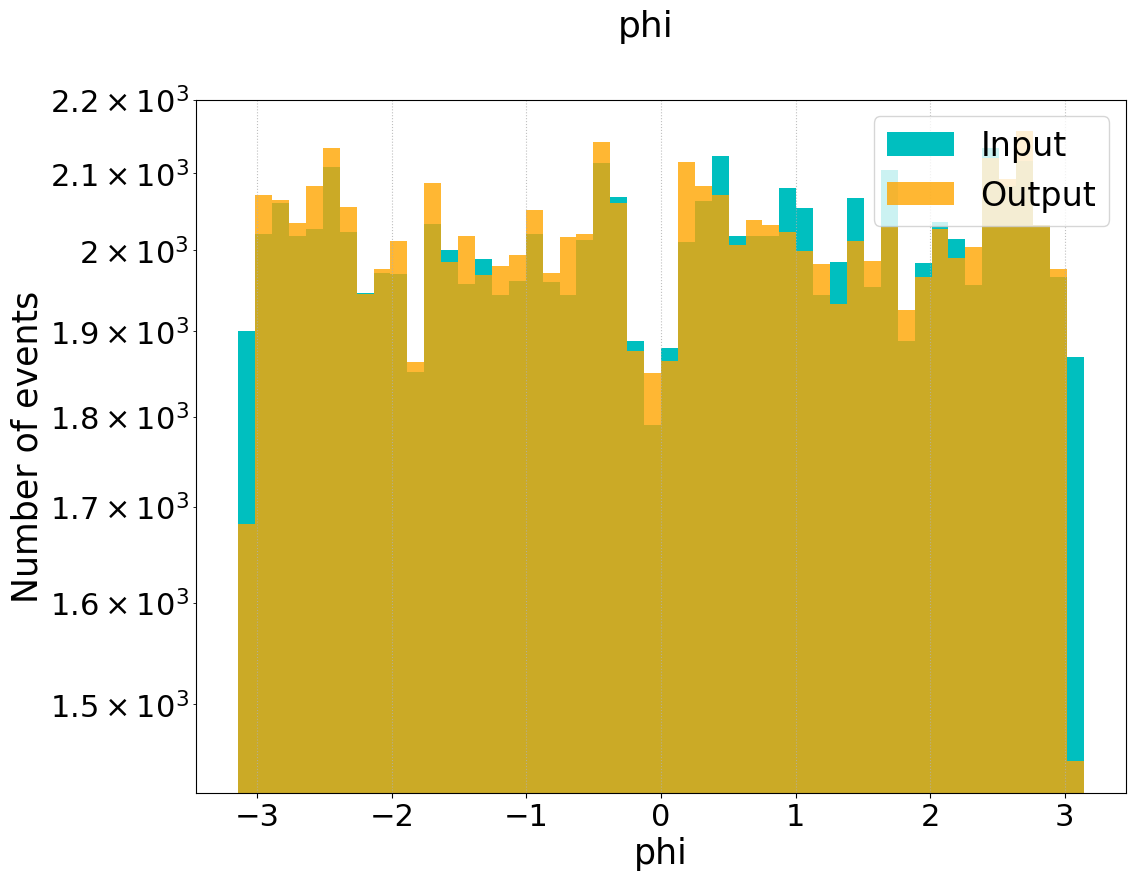

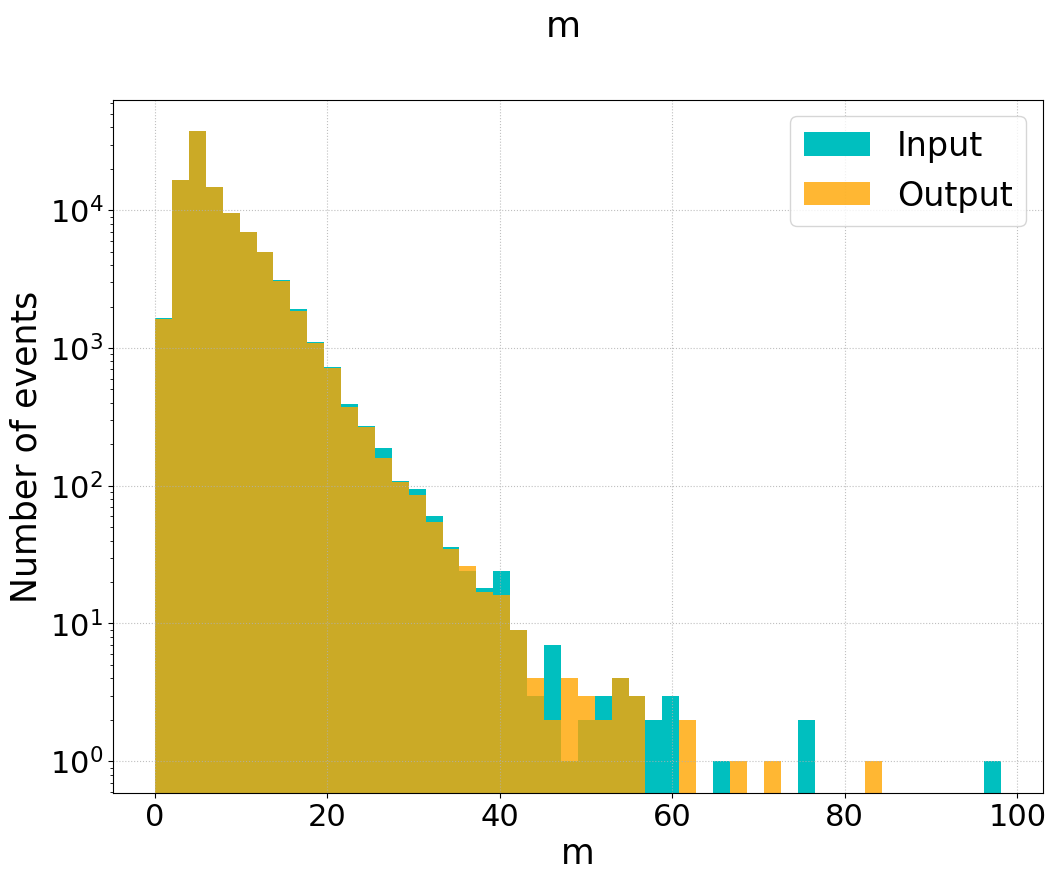

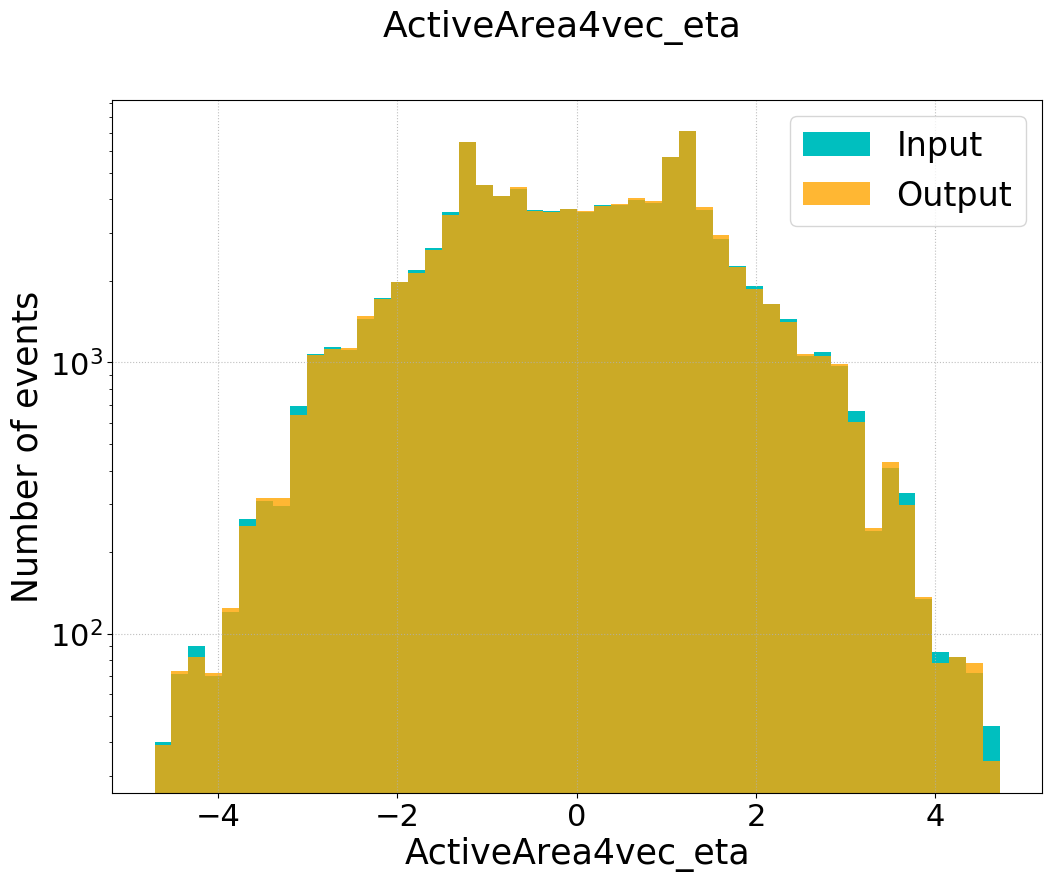

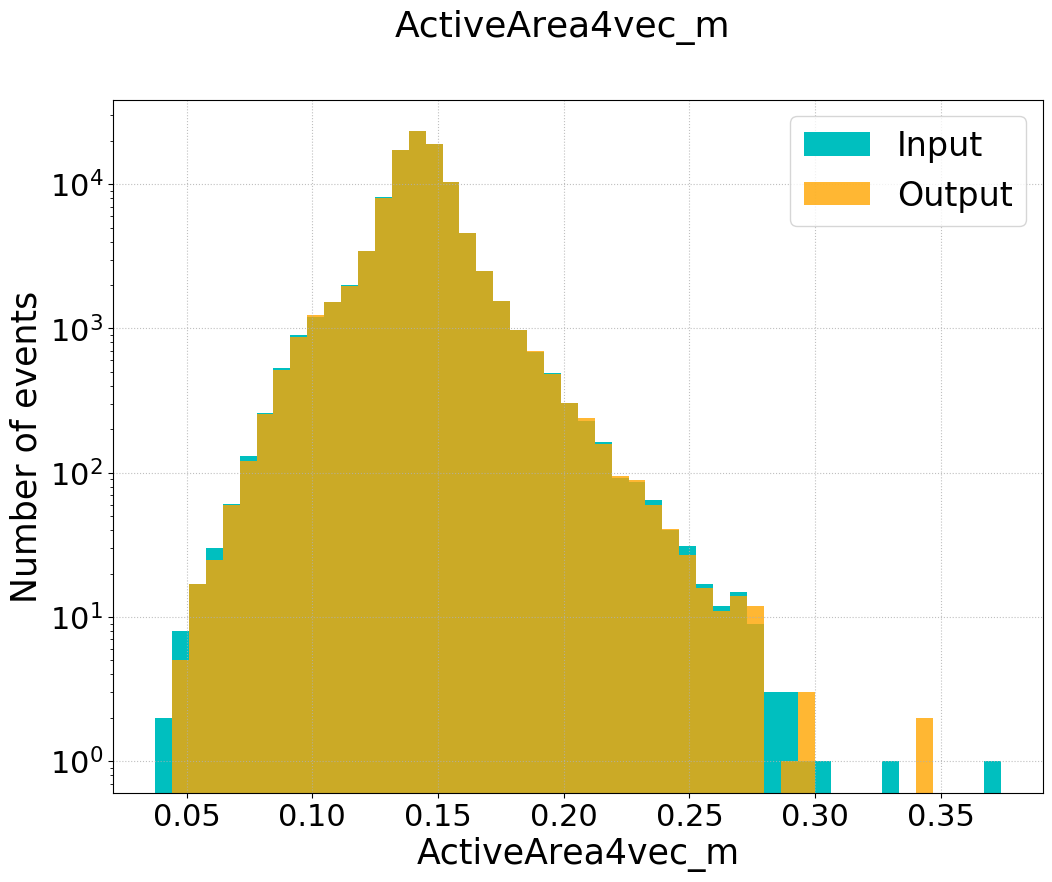

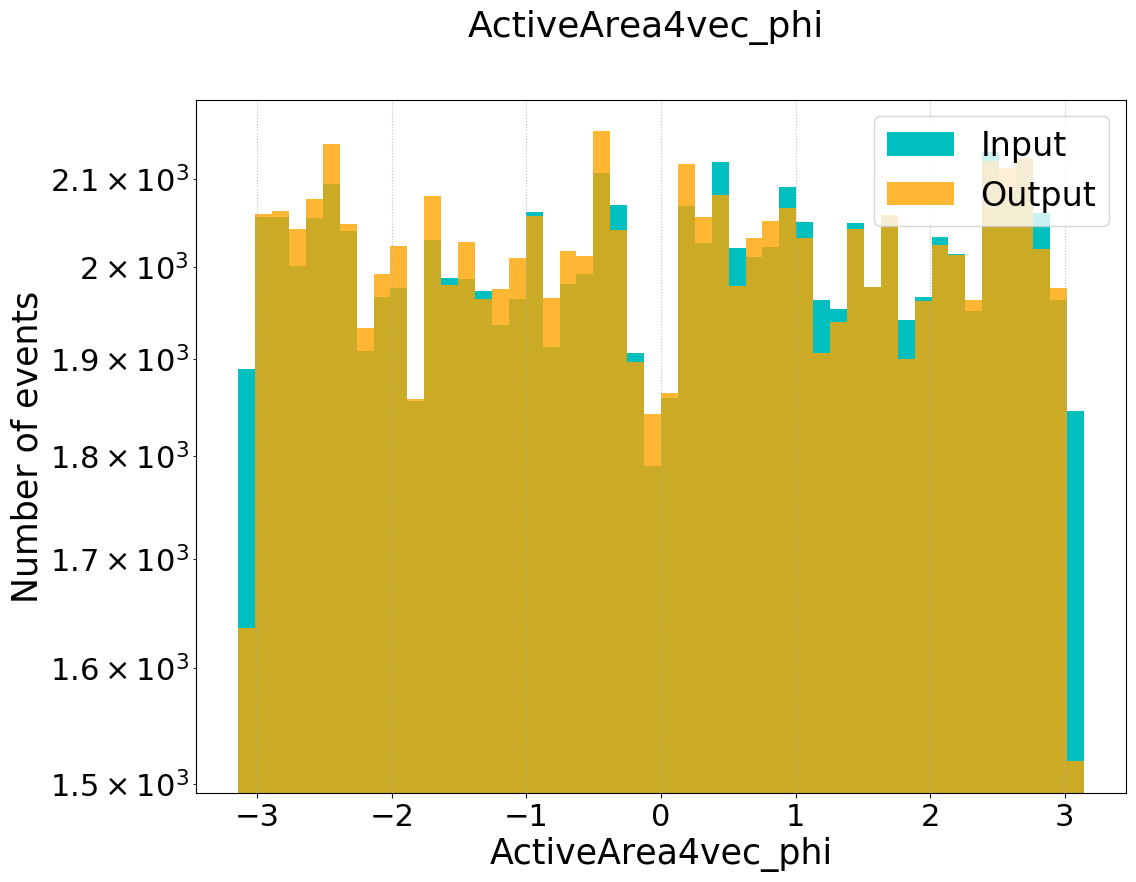

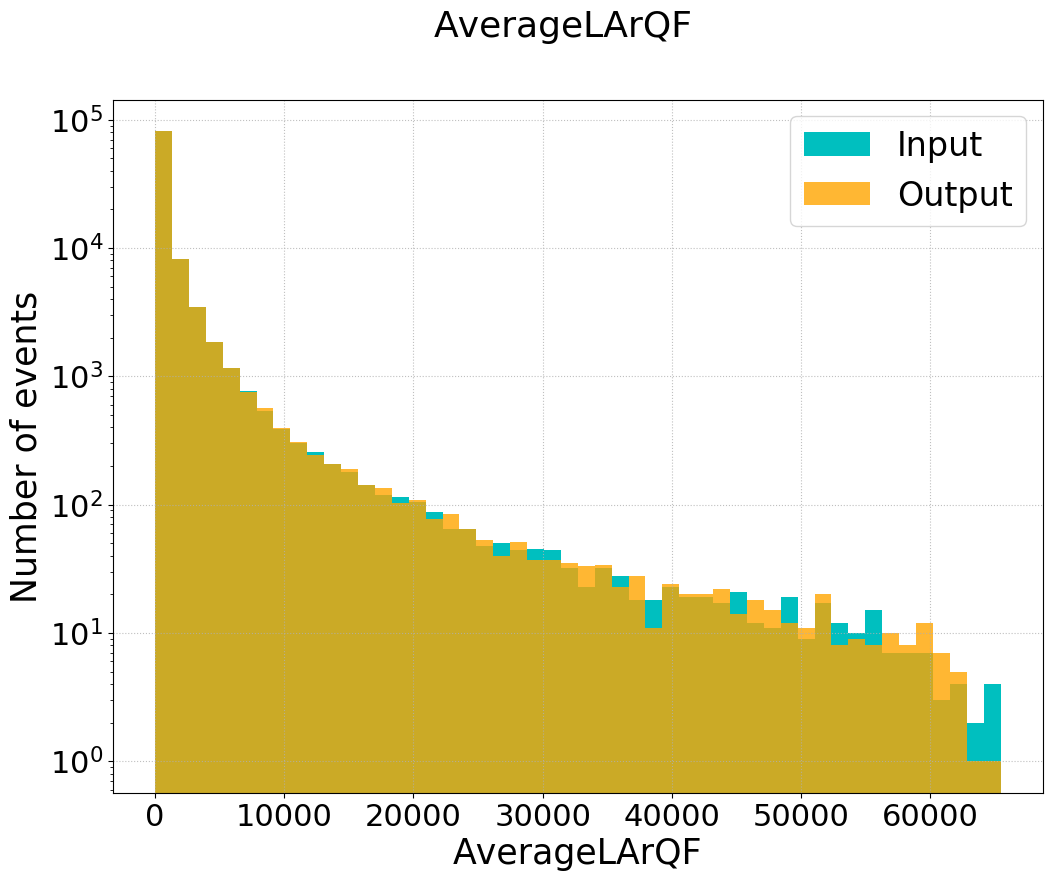

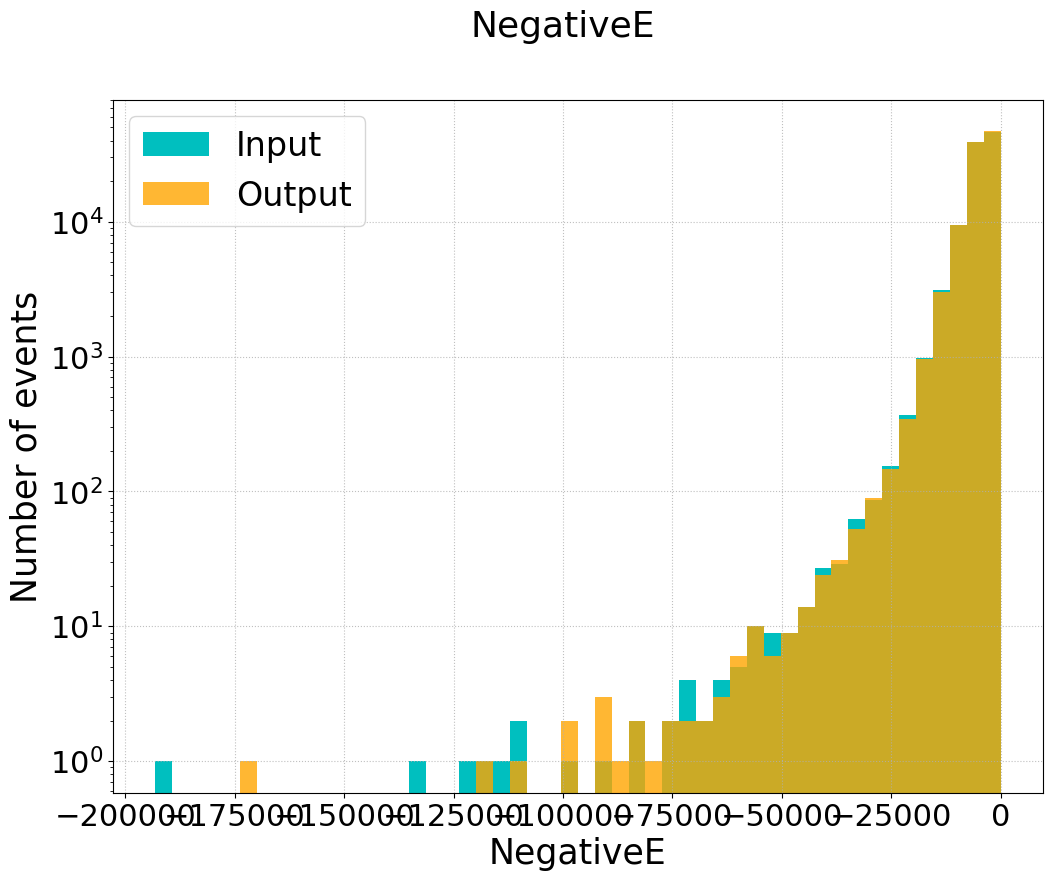

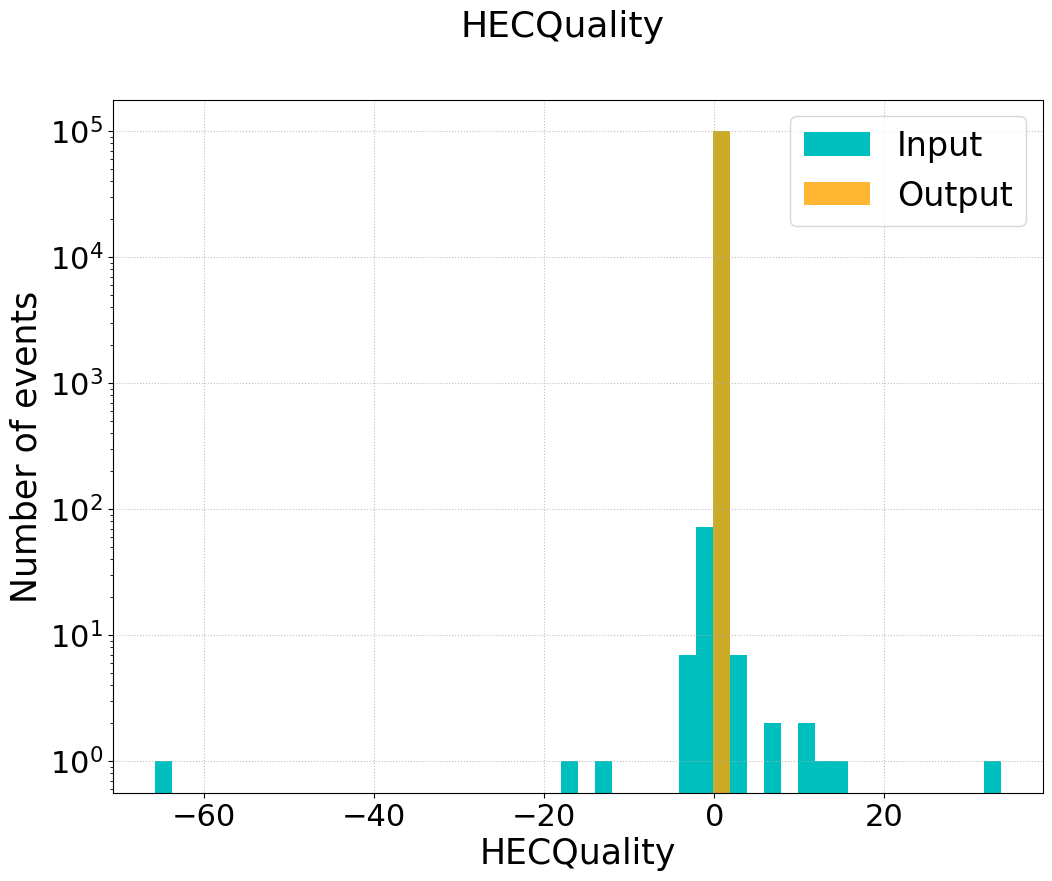

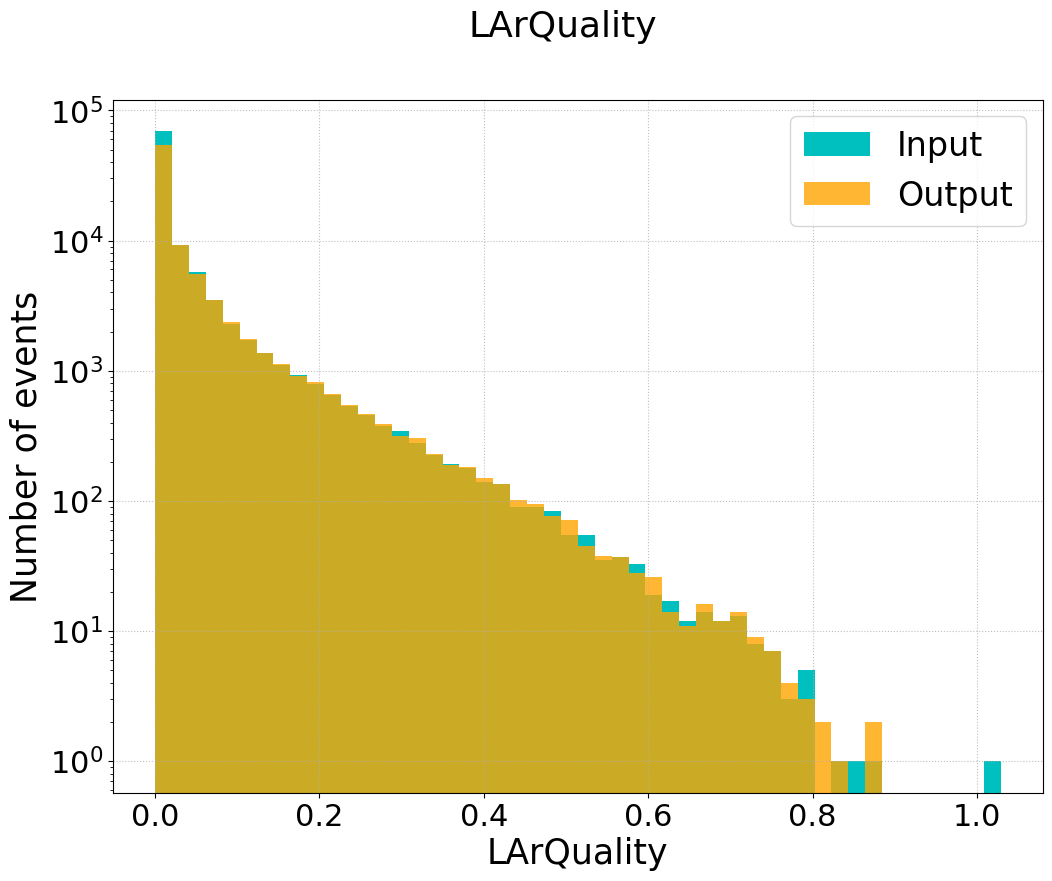

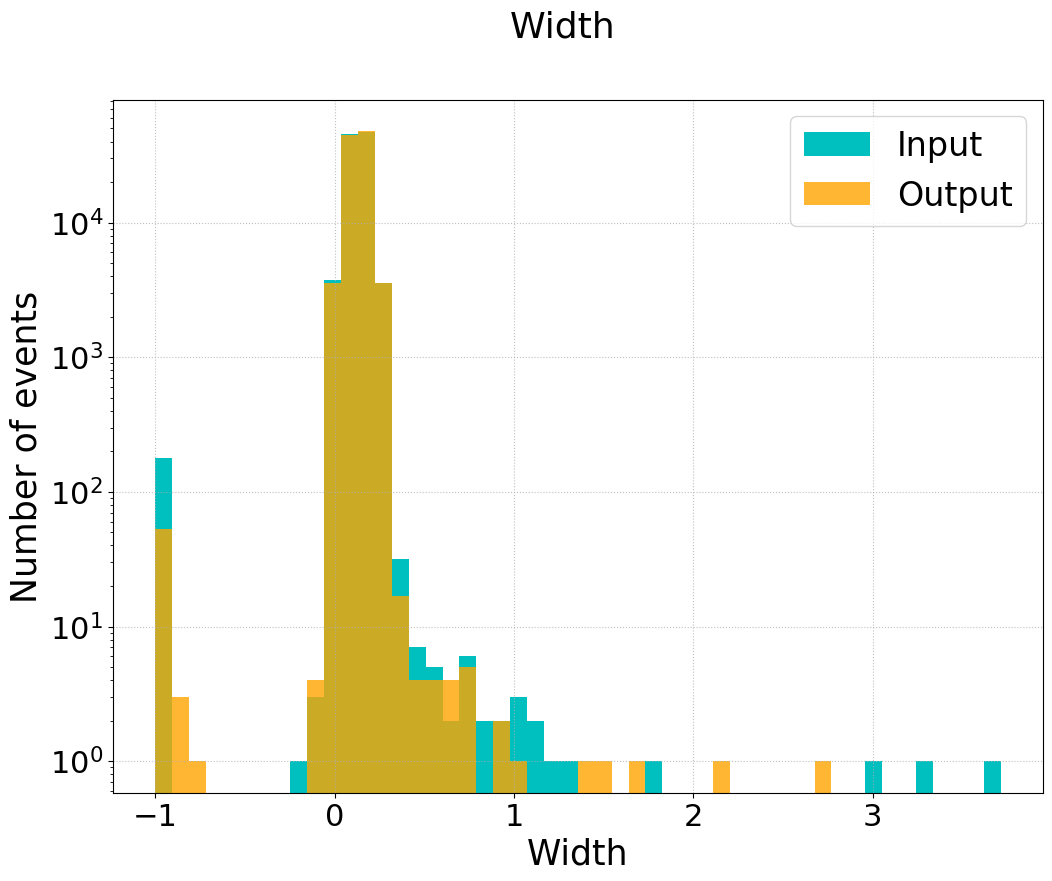

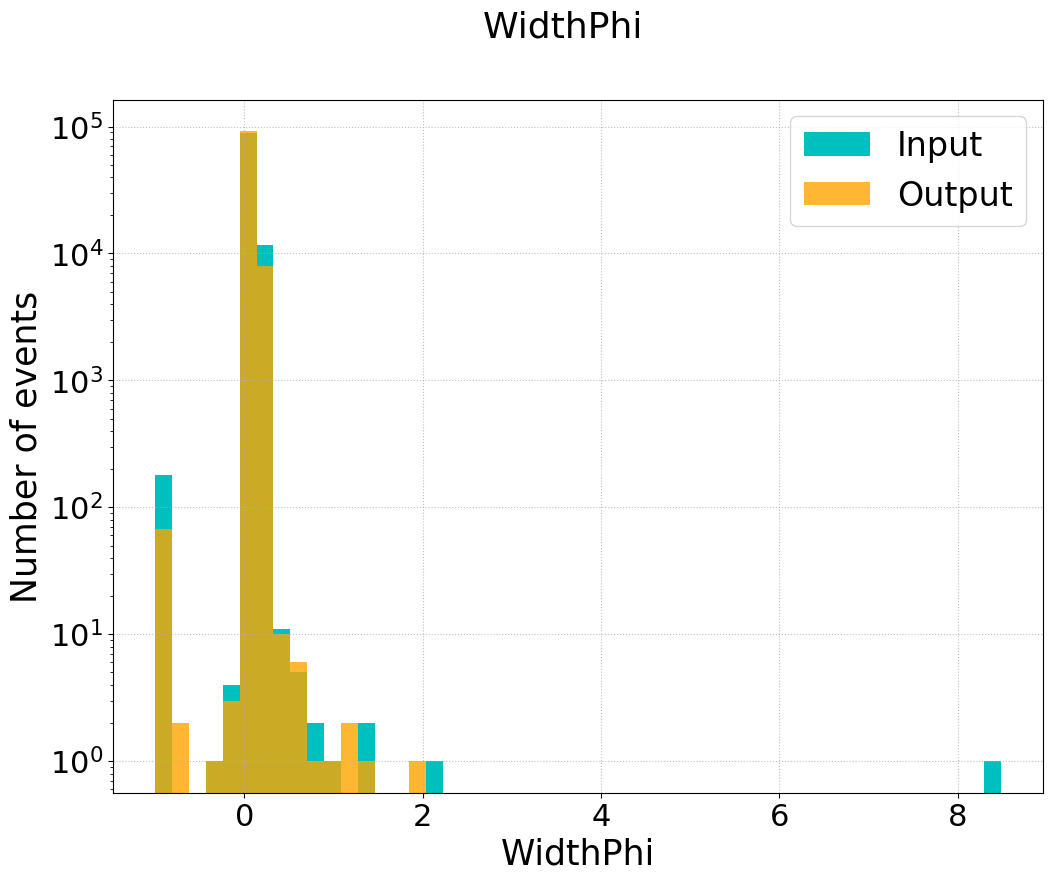

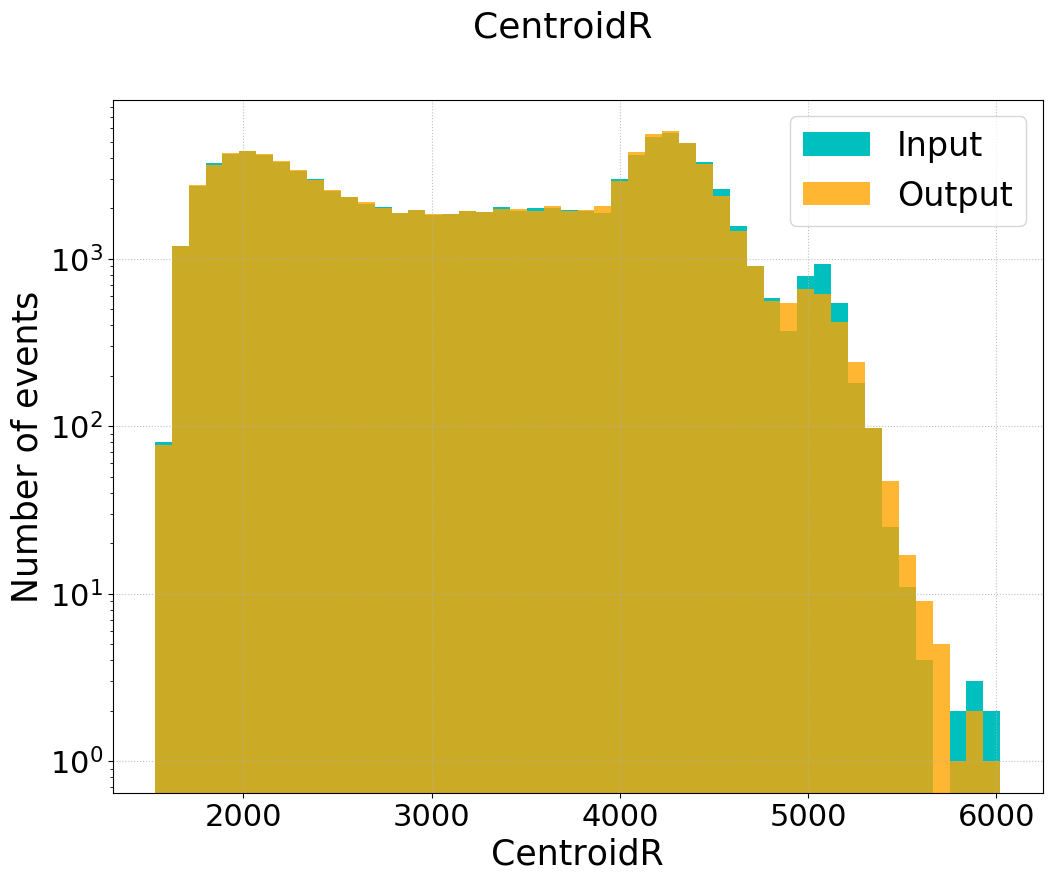

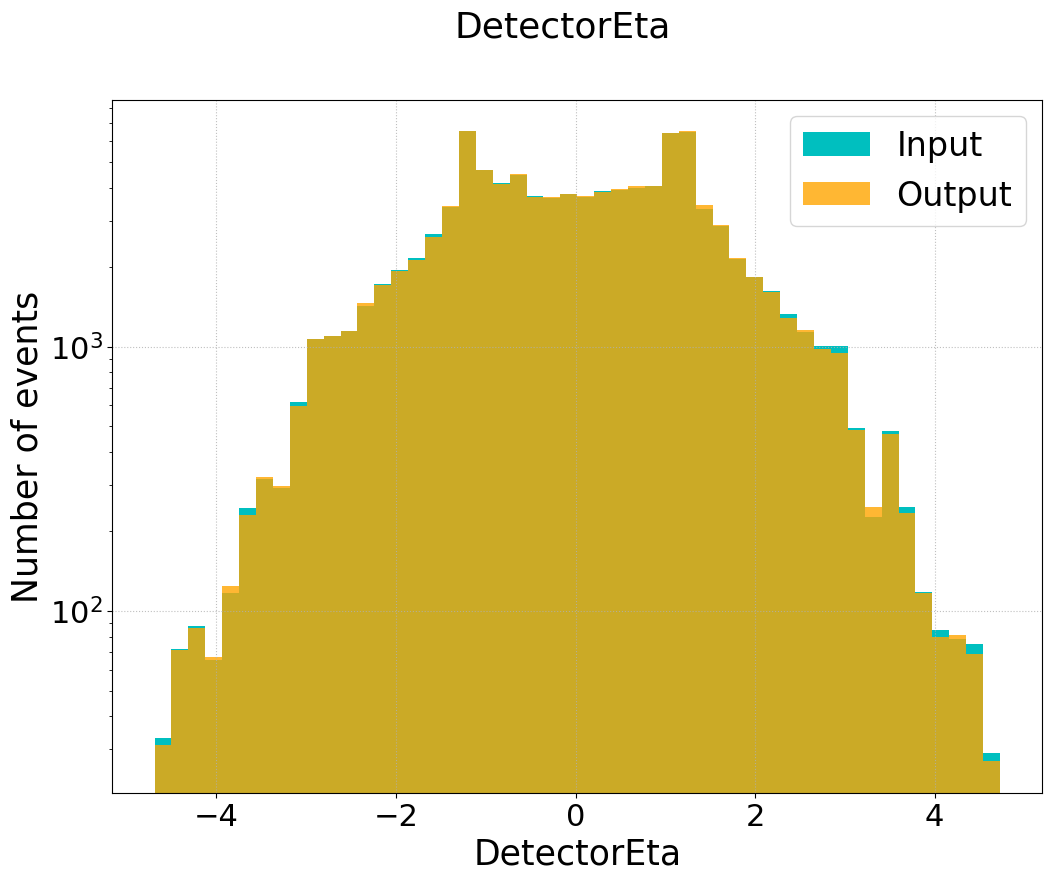

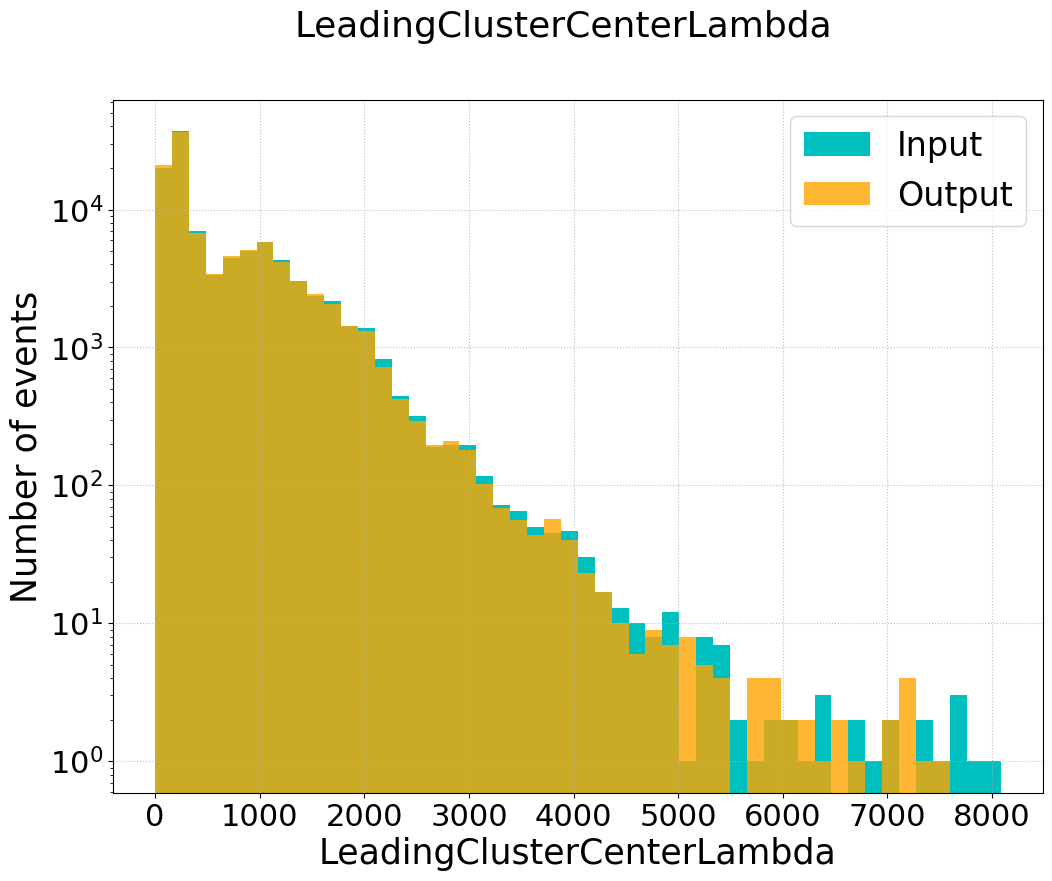

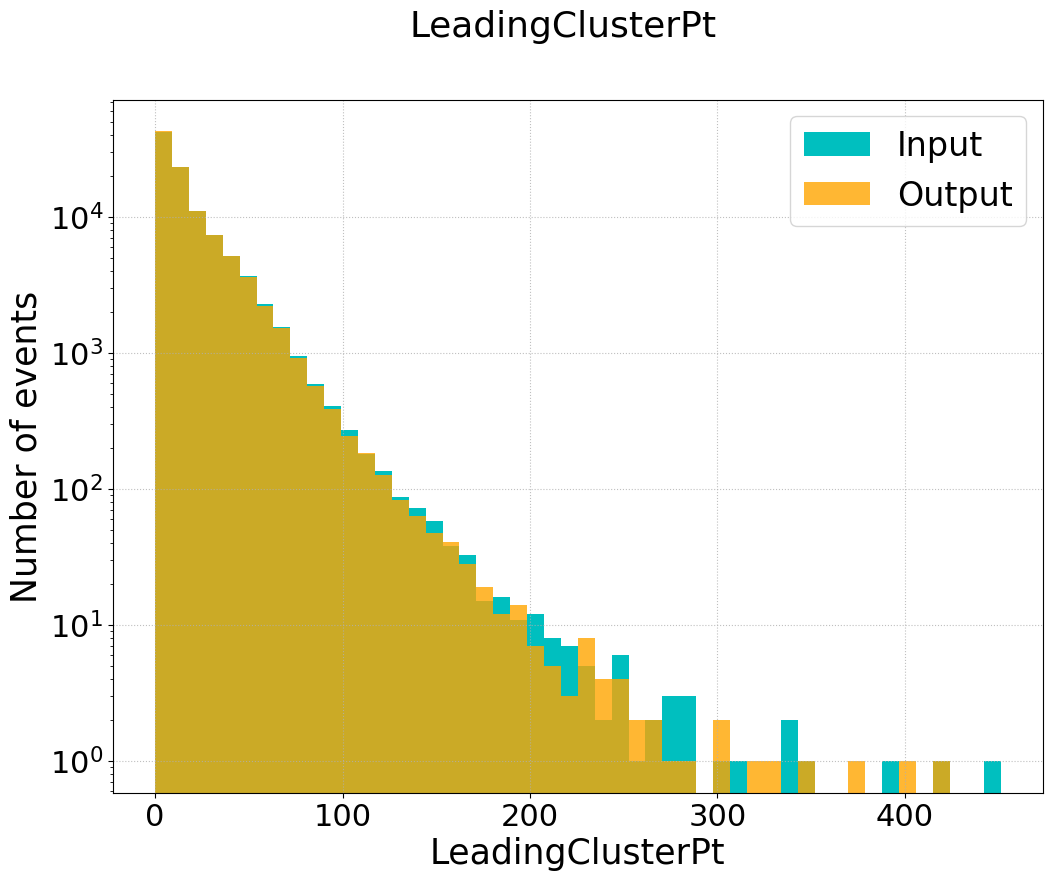

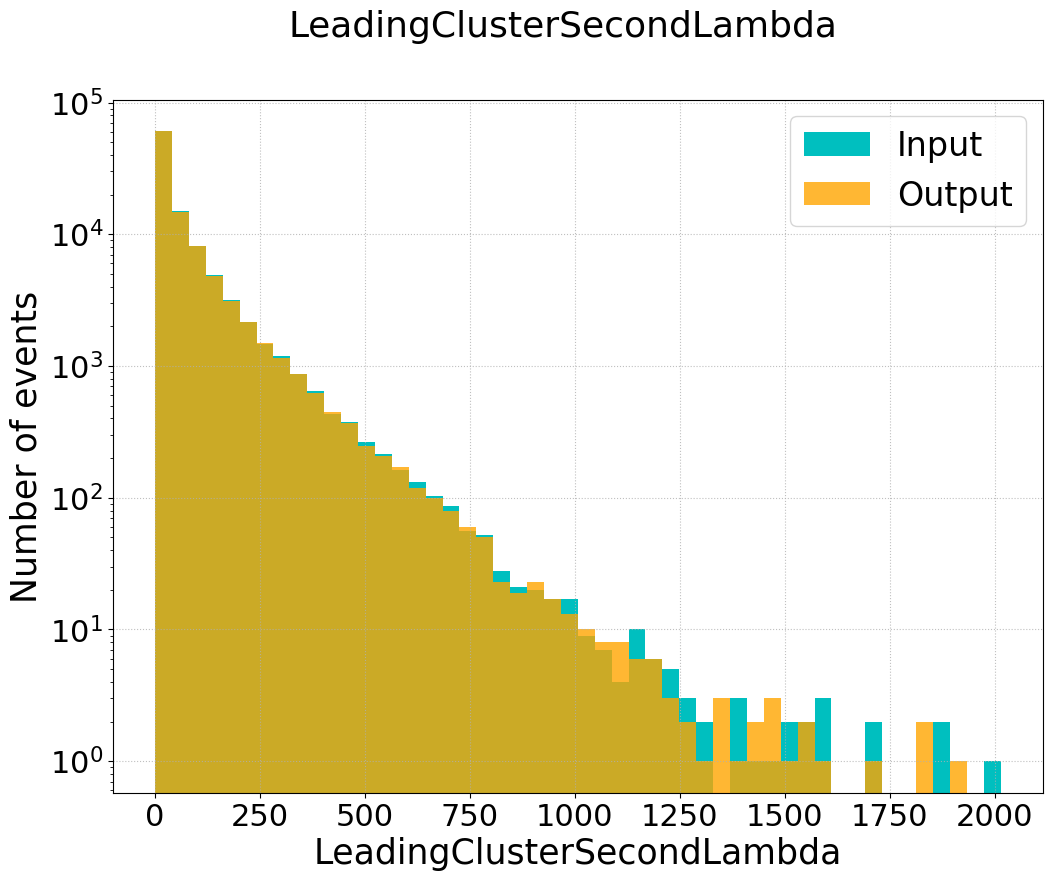

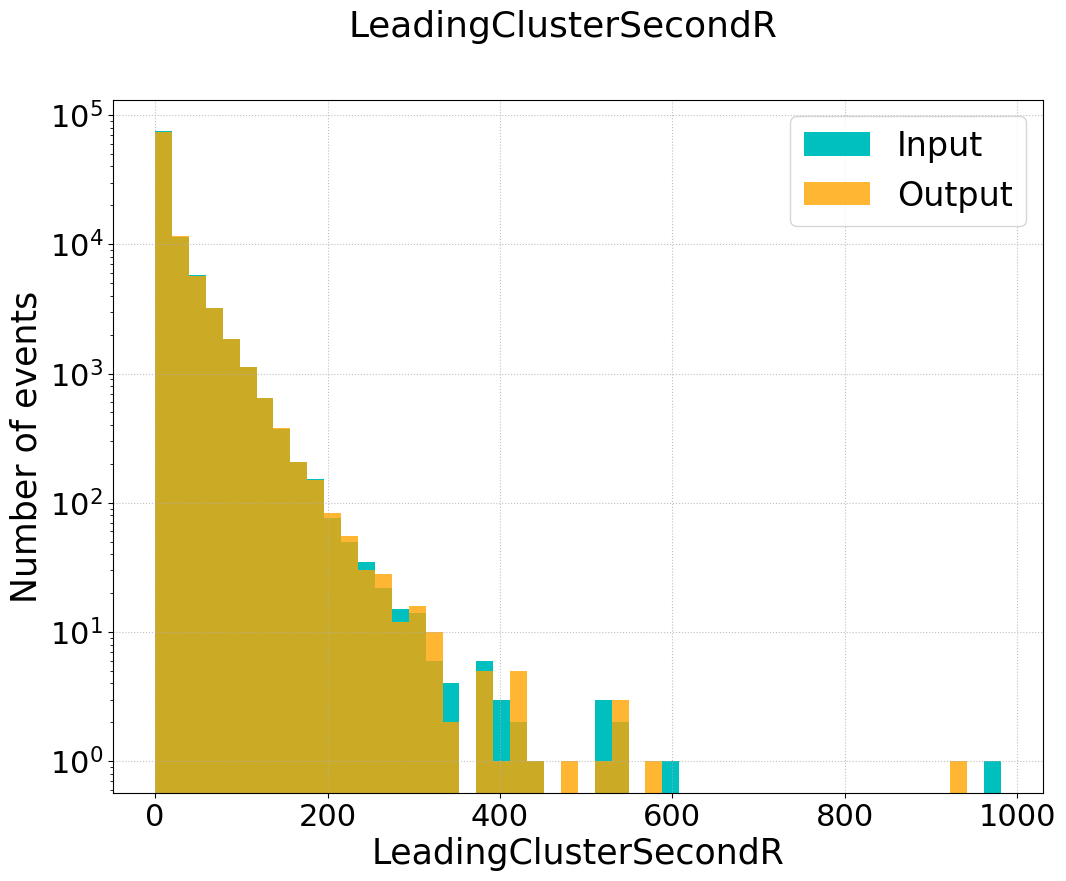

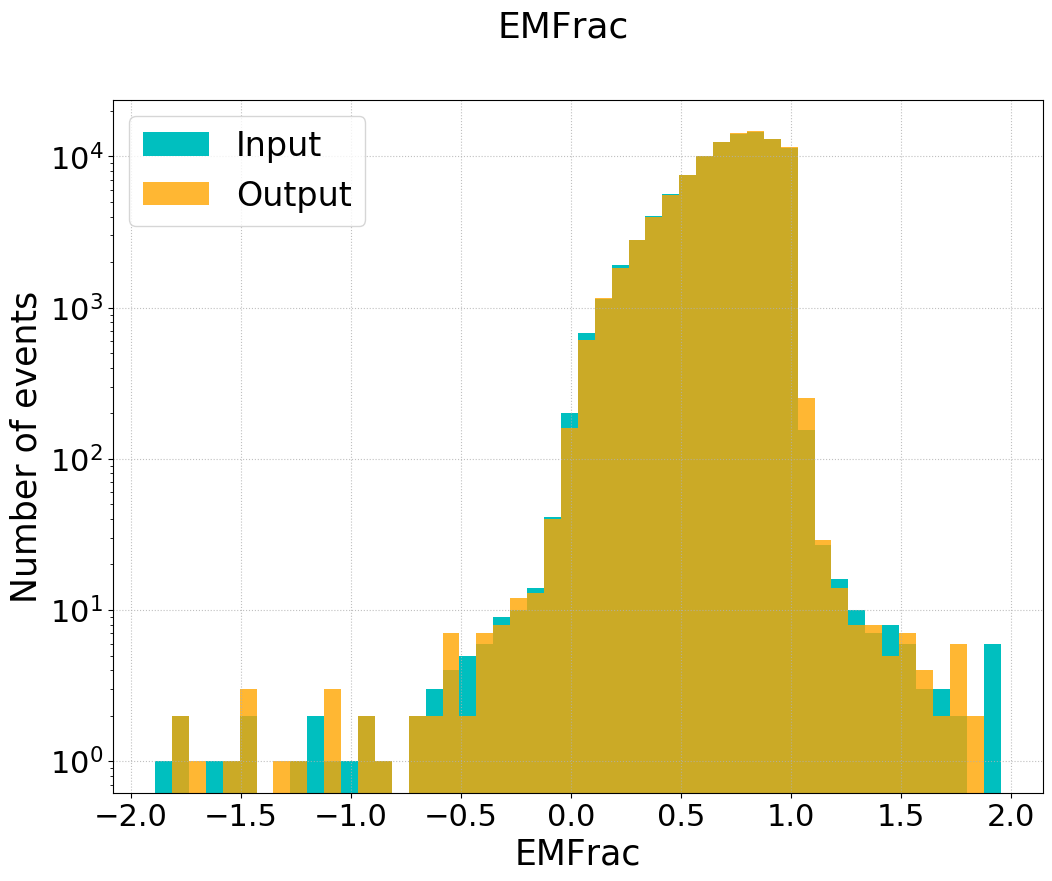

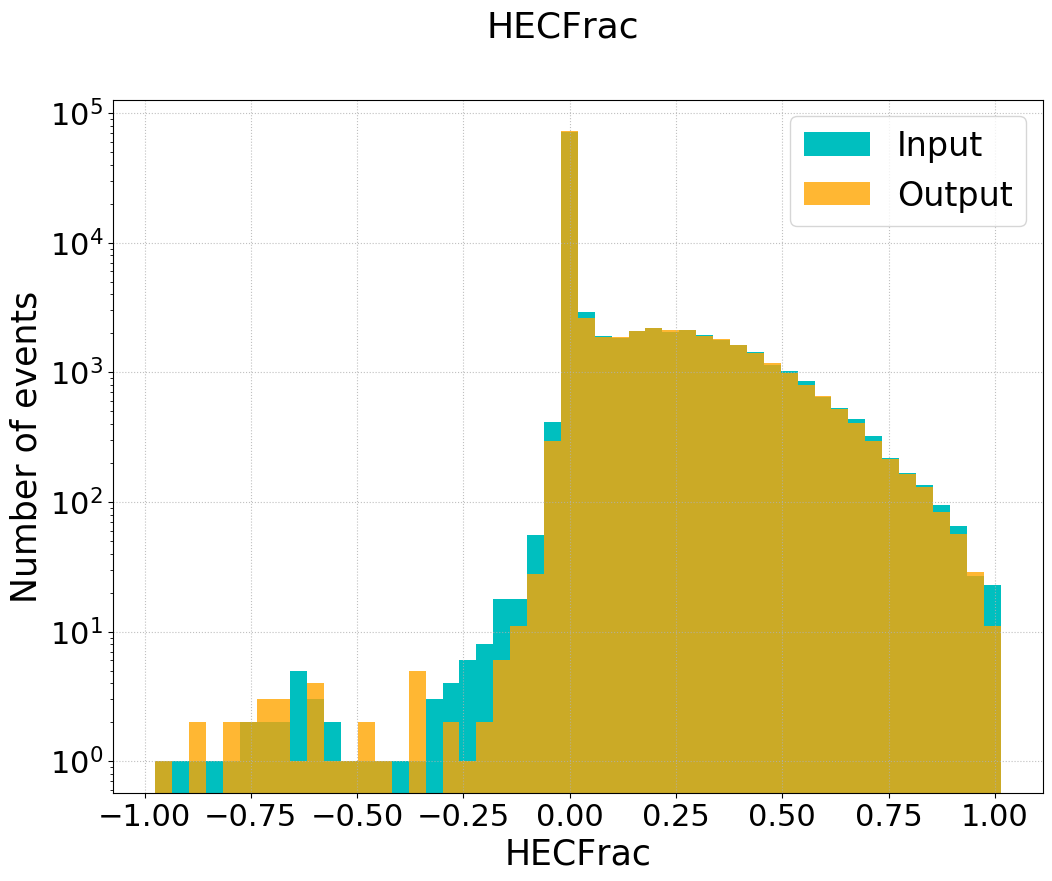

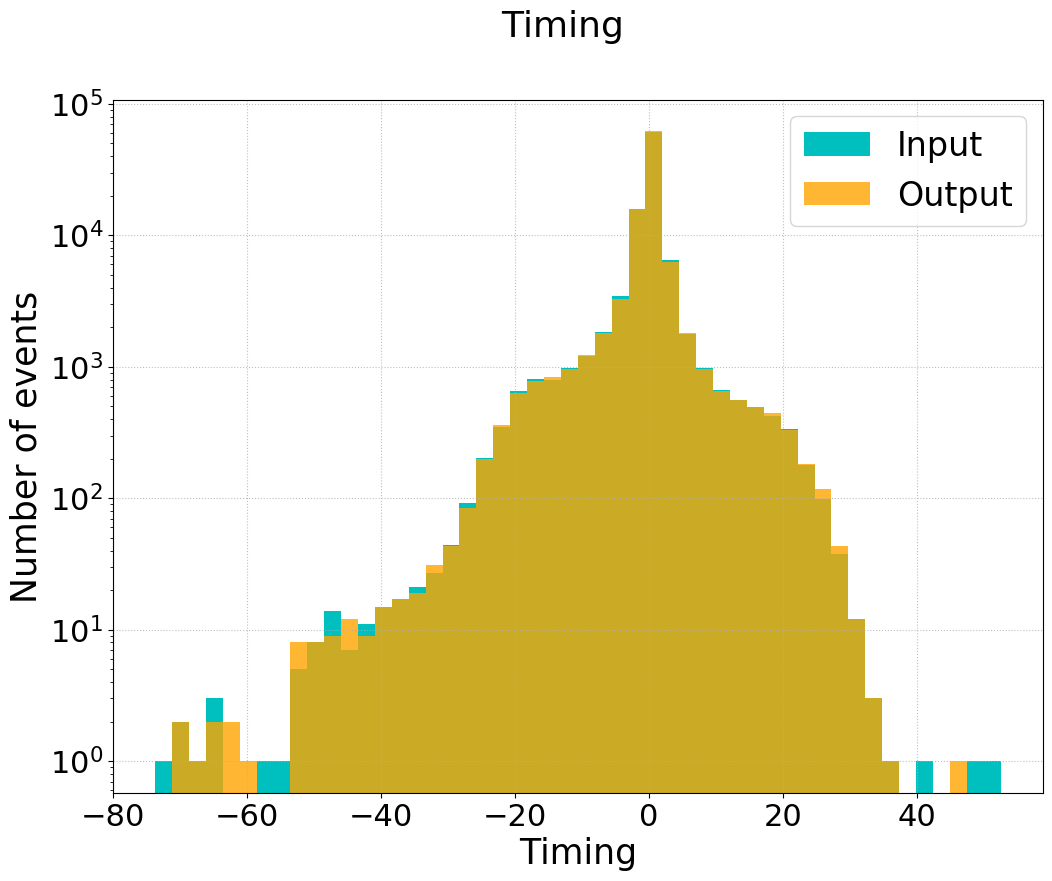

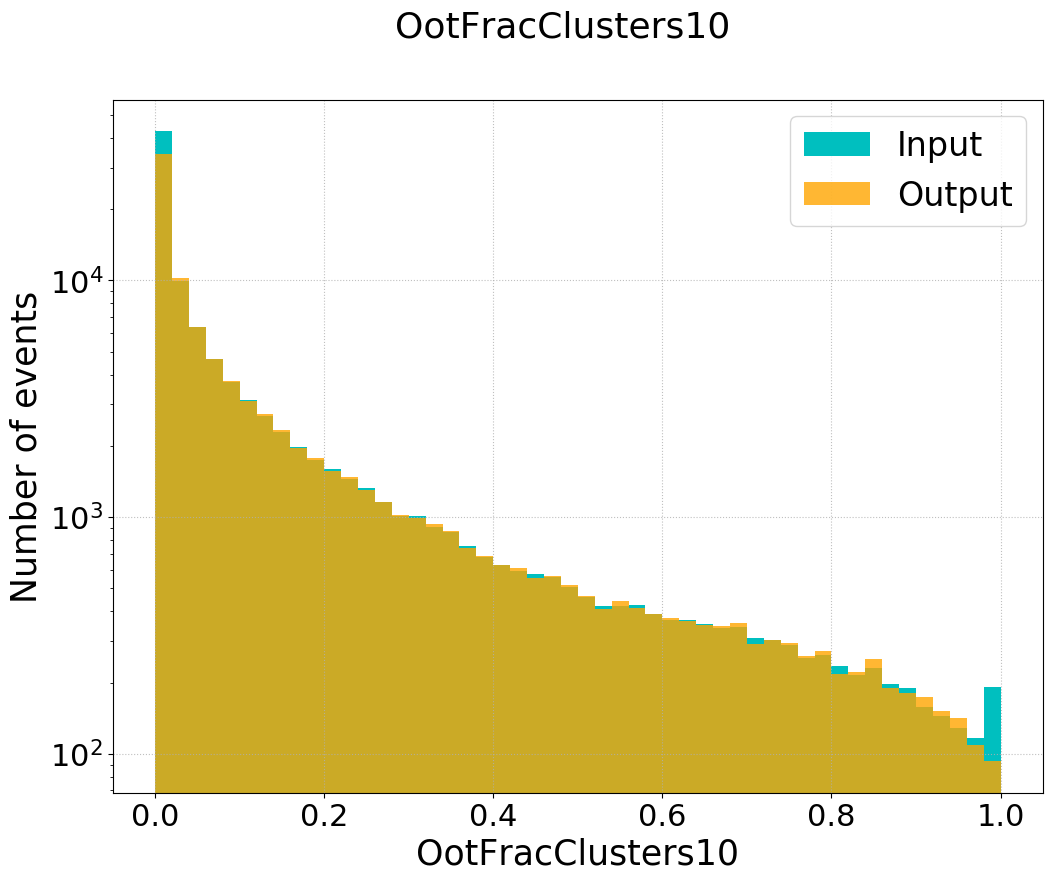

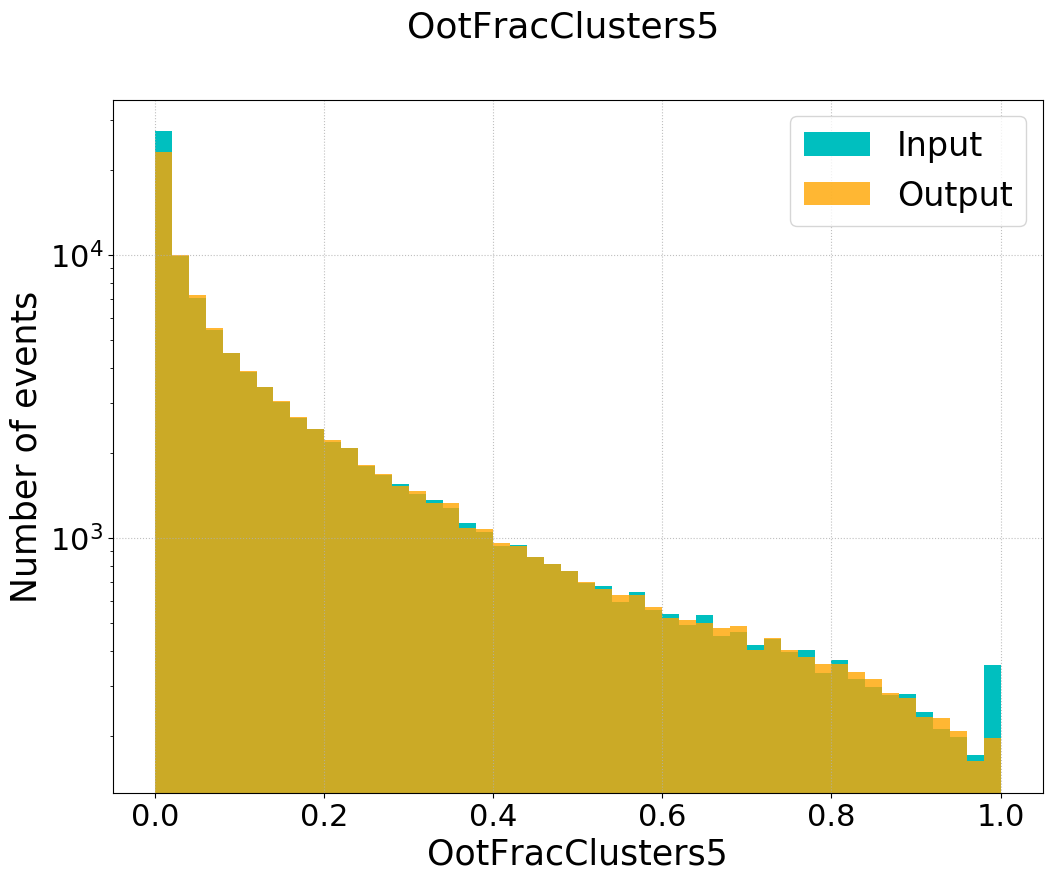

In [87]:
data = unnormalized_data_df.values
pred = unnormalized_pred_df.values

alph = 0.8
n_bins = 50
for kk in np.arange(24):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    plt.legend()